# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-mc'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [13]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [16]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(most_uncertain_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8278, F1 Micro: 0.0483, F1 Macro: 0.017
Epoch 2/10, Train Loss: 0.4112, Accuracy: 0.8287, F1 Micro: 0.0251, F1 Macro: 0.0109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3817, Accuracy: 0.8313, F1 Micro: 0.0562, F1 Macro: 0.023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8534, F1 Micro: 0.3322, F1 Macro: 0.1087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3425, Accuracy: 0.8667, F1 Micro: 0.4499, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3131, Accuracy: 0.8731, F1 Micro: 0.6036, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2691, Accuracy: 0.8766, F1 Micro: 0.6219, F1 Macro: 0.3077
Epoch 8/10, Train Loss: 0.2634, Accuracy: 0.8822, F1 Micro: 0.5944, F1 Macro: 0.2945
Epoch 9/10, Train Loss: 0.2253, Accuracy: 0.8804, F1 Micro: 0.5629, F1 Macro: 0.2872
Epoch 10/10, Train Loss: 0.1952, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.492, Accuracy: 0.8458, F1 Micro: 0.2793, F1 Macro: 0.0928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4056, Accuracy: 0.8522, F1 Micro: 0.3721, F1 Macro: 0.1137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3795, Accuracy: 0.8802, F1 Micro: 0.5655, F1 Macro: 0.274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.321, Accuracy: 0.8901, F1 Micro: 0.6032, F1 Macro: 0.3468
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2576, Accuracy: 0.8997, F1 Micro: 0.671, F1 Macro: 0.4227
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2131, Accuracy: 0.9013, F1 Micro: 0.6902, F1 Macro: 0.4469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1867, Accuracy: 0.9025, F1 Micro: 0.7179, F1 Macro: 0.5136
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1582, Accuracy: 0.9047, F1 Micro: 0.7208, F1 Macro: 0.5168
Epoch 9/10, Train Loss: 0.136, Accuracy: 0.9059, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4683, Accuracy: 0.8466, F1 Micro: 0.3319, F1 Macro: 0.1033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3938, Accuracy: 0.8585, F1 Micro: 0.424, F1 Macro: 0.1557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3447, Accuracy: 0.8998, F1 Micro: 0.6851, F1 Macro: 0.4508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.283, Accuracy: 0.909, F1 Micro: 0.725, F1 Macro: 0.5079
Epoch 5/10, Train Loss: 0.2292, Accuracy: 0.908, F1 Micro: 0.7151, F1 Macro: 0.492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1827, Accuracy: 0.91, F1 Micro: 0.7425, F1 Macro: 0.5342
Epoch 7/10, Train Loss: 0.1507, Accuracy: 0.9125, F1 Micro: 0.7209, F1 Macro: 0.5386
Epoch 8/10, Train Loss: 0.1183, Accuracy: 0.914, F1 Micro: 0.7312, F1 Macro: 0.5581
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1008, Accuracy: 0.9164, F1 Micro: 0.7485, F1 Macro: 0.5905
Epoch 10/10, Train Loss: 0.0868, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4599, Accuracy: 0.8451, F1 Micro: 0.4004, F1 Macro: 0.1272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3798, Accuracy: 0.8921, F1 Micro: 0.6533, F1 Macro: 0.3607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3172, Accuracy: 0.9078, F1 Micro: 0.7243, F1 Macro: 0.5276
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.263, Accuracy: 0.9092, F1 Micro: 0.7381, F1 Macro: 0.5358
Epoch 5/10, Train Loss: 0.2103, Accuracy: 0.9133, F1 Micro: 0.7333, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1665, Accuracy: 0.9142, F1 Micro: 0.7448, F1 Macro: 0.5715
Epoch 7/10, Train Loss: 0.1366, Accuracy: 0.9118, F1 Micro: 0.7447, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1178, Accuracy: 0.9155, F1 Micro: 0.7509, F1 Macro: 0.5814
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9138, F1 Micro: 0.7449, F1 Macro: 0.6039
Epoch 10/10, Train Loss: 0.0815, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4512, Accuracy: 0.8504, F1 Micro: 0.4101, F1 Macro: 0.1219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3651, Accuracy: 0.903, F1 Micro: 0.6929, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3094, Accuracy: 0.9113, F1 Micro: 0.7326, F1 Macro: 0.5384
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2508, Accuracy: 0.9162, F1 Micro: 0.757, F1 Macro: 0.585
Epoch 5/10, Train Loss: 0.1933, Accuracy: 0.9132, F1 Micro: 0.7559, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1571, Accuracy: 0.9178, F1 Micro: 0.7637, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9197, F1 Micro: 0.7659, F1 Macro: 0.6281
Epoch 8/10, Train Loss: 0.1113, Accuracy: 0.92, F1 Micro: 0.7553, F1 Macro: 0.6341
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9197, F1 Micro: 0.7629, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4514, Accuracy: 0.8642, F1 Micro: 0.5061, F1 Macro: 0.1954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3542, Accuracy: 0.9058, F1 Micro: 0.71, F1 Macro: 0.4953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2935, Accuracy: 0.9158, F1 Micro: 0.75, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2382, Accuracy: 0.9201, F1 Micro: 0.7572, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1866, Accuracy: 0.9185, F1 Micro: 0.7703, F1 Macro: 0.6313
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.919, F1 Micro: 0.7649, F1 Macro: 0.638
Epoch 7/10, Train Loss: 0.1249, Accuracy: 0.9209, F1 Micro: 0.7559, F1 Macro: 0.6286
Epoch 8/10, Train Loss: 0.1025, Accuracy: 0.9215, F1 Micro: 0.7669, F1 Macro: 0.6355
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9211, F1 Micro: 0.7698, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.07, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8818, F1 Micro: 0.6088, F1 Macro: 0.3189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3453, Accuracy: 0.911, F1 Micro: 0.7304, F1 Macro: 0.5509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2819, Accuracy: 0.9173, F1 Micro: 0.7565, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2275, Accuracy: 0.9209, F1 Micro: 0.7618, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.923, F1 Micro: 0.7638, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9222, F1 Micro: 0.7743, F1 Macro: 0.6581
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9226, F1 Micro: 0.767, F1 Macro: 0.6683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9233, F1 Micro: 0.7791, F1 Macro: 0.6837
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.9234, F1 Micro: 0.7762, F1 Macro: 0.6938
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.8873, F1 Micro: 0.5997, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3299, Accuracy: 0.9101, F1 Micro: 0.7307, F1 Macro: 0.5349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2673, Accuracy: 0.9218, F1 Micro: 0.7584, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2149, Accuracy: 0.9236, F1 Micro: 0.7601, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.9244, F1 Micro: 0.7799, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.925, F1 Micro: 0.7811, F1 Macro: 0.6642
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9259, F1 Micro: 0.7792, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9249, F1 Micro: 0.7861, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9285, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4282, Accuracy: 0.8929, F1 Micro: 0.6588, F1 Macro: 0.3856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3174, Accuracy: 0.9127, F1 Micro: 0.754, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2548, Accuracy: 0.9204, F1 Micro: 0.7639, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2064, Accuracy: 0.9173, F1 Micro: 0.7709, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9258, F1 Micro: 0.7834, F1 Macro: 0.6943
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9273, F1 Micro: 0.7779, F1 Macro: 0.6967
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9252, F1 Micro: 0.78, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9299, F1 Micro: 0.7894, F1 Macro: 0.7048
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9248, F1 Micro: 0.7816, F1 Macro: 0.7131
Epoch 10/10, Train Loss: 0.0623, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4223, Accuracy: 0.8921, F1 Micro: 0.655, F1 Macro: 0.3793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3129, Accuracy: 0.9149, F1 Micro: 0.737, F1 Macro: 0.5408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.9232, F1 Micro: 0.7656, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.204, Accuracy: 0.927, F1 Micro: 0.7741, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9256, F1 Micro: 0.7862, F1 Macro: 0.6711
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9264, F1 Micro: 0.783, F1 Macro: 0.6767
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9267, F1 Micro: 0.7845, F1 Macro: 0.712
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9269, F1 Micro: 0.7858, F1 Macro: 0.7172
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9277, F1 Micro: 0.7844, F1 Macro: 0.726
Epoch 10/10, Train Loss: 0.064, Accuracy: 0.9256, F1 Micro: 0.7859, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.897, F1 Micro: 0.655, F1 Macro: 0.4284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3054, Accuracy: 0.9151, F1 Micro: 0.7478, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.9223, F1 Micro: 0.7651, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.9274, F1 Micro: 0.7809, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9271, F1 Micro: 0.7838, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9285, F1 Micro: 0.7839, F1 Macro: 0.7151
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.927, F1 Micro: 0.7802, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9259, F1 Micro: 0.7874, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.929, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4079, Accuracy: 0.898, F1 Micro: 0.6498, F1 Macro: 0.4524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.9182, F1 Micro: 0.7465, F1 Macro: 0.5863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9249, F1 Micro: 0.7758, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.927, F1 Micro: 0.7855, F1 Macro: 0.6816
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9235, F1 Micro: 0.7789, F1 Macro: 0.6875
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9264, F1 Micro: 0.784, F1 Macro: 0.7107
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9257, F1 Micro: 0.779, F1 Macro: 0.7019
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9251, F1 Micro: 0.7823, F1 Macro: 0.7207
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9231, F1 Micro: 0.7818, F1 Macro: 0.7189
Epoch 10/10, Train Loss: 0.0594, Accuracy: 0.9267, F1 Micro: 0.7817, F1 Macro: 0.7157

 Iteration 7336: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.9009, F1 Micro: 0.6671, F1 Macro: 0.4338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.9204, F1 Micro: 0.7572, F1 Macro: 0.6115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9237, F1 Micro: 0.7628, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9277, F1 Micro: 0.7792, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9277, F1 Micro: 0.7907, F1 Macro: 0.7071
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9266, F1 Micro: 0.7869, F1 Macro: 0.7145
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9265, F1 Micro: 0.7782, F1 Macro: 0.687
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9262, F1 Micro: 0.7879, F1 Macro: 0.7162
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9257, F1 Micro: 0.7829, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0585, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.9021, F1 Micro: 0.68, F1 Macro: 0.4343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2755, Accuracy: 0.9191, F1 Micro: 0.7578, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.925, F1 Micro: 0.765, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.925, F1 Micro: 0.7809, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9283, F1 Micro: 0.7814, F1 Macro: 0.6869
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9272, F1 Micro: 0.7782, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.928, F1 Micro: 0.7858, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9267, F1 Micro: 0.7878, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.929, F1 Micro: 0.7885, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3872, Accuracy: 0.9025, F1 Micro: 0.6921, F1 Macro: 0.4517
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.9204, F1 Micro: 0.7617, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9249, F1 Micro: 0.7757, F1 Macro: 0.6371
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9276, F1 Micro: 0.776, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9261, F1 Micro: 0.7867, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.9274, F1 Micro: 0.7905, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9295, F1 Micro: 0.7921, F1 Macro: 0.7277
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9266, F1 Micro: 0.7895, F1 Macro: 0.7316
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9278, F1 Micro: 0.7897, F1 Macro: 0.7266
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.8992, F1 Micro: 0.7044, F1 Macro: 0.5419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9208, F1 Micro: 0.7553, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9256, F1 Micro: 0.768, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9277, F1 Micro: 0.7871, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9284, F1 Micro: 0.7879, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9282, F1 Micro: 0.7891, F1 Macro: 0.6805
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9263, F1 Micro: 0.7882, F1 Macro: 0.7112
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9239, F1 Micro: 0.7845, F1 Macro: 0.7247
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9279, F1 Micro: 0.7885, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.9006, F1 Micro: 0.6568, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.916, F1 Micro: 0.7569, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9264, F1 Micro: 0.771, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9249, F1 Micro: 0.7769, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9289, F1 Micro: 0.7925, F1 Macro: 0.7037
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9284, F1 Micro: 0.785, F1 Macro: 0.701
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.929, F1 Micro: 0.7899, F1 Macro: 0.7218
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9278, F1 Micro: 0.7901, F1 Macro: 0.7247
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9267, F1 Micro: 0.7766, F1 Macro: 0.7087
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.924, F1 Micro: 0.784, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.9049, F1 Micro: 0.7211, F1 Macro: 0.5223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.919, F1 Micro: 0.7517, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.9248, F1 Micro: 0.7768, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.929, F1 Micro: 0.7832, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9287, F1 Micro: 0.7875, F1 Macro: 0.7077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9257, F1 Micro: 0.7892, F1 Macro: 0.7163
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9247, F1 Micro: 0.7855, F1 Macro: 0.7111
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9234, F1 Micro: 0.7822, F1 Macro: 0.7133
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9276, F1 Micro: 0.782, F1 Macro: 0.709
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.9065, F1 Micro: 0.703, F1 Macro: 0.4787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9197, F1 Micro: 0.7444, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.924, F1 Micro: 0.7783, F1 Macro: 0.6421
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9268, F1 Micro: 0.7767, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9278, F1 Micro: 0.783, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.926, F1 Micro: 0.7872, F1 Macro: 0.7082
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9275, F1 Micro: 0.7832, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9286, F1 Micro: 0.7887, F1 Macro: 0.7167
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9249, F1 Micro: 0.787, F1 Macro: 0.7271
Epoch 10/10, Train Loss: 0.0468, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3624, Accuracy: 0.9034, F1 Micro: 0.6687, F1 Macro: 0.4928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9202, F1 Micro: 0.7552, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9275, F1 Micro: 0.7815, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9262, F1 Micro: 0.7873, F1 Macro: 0.6814
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9237, F1 Micro: 0.7845, F1 Macro: 0.6814
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.93, F1 Micro: 0.7923, F1 Macro: 0.7248
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9257, F1 Micro: 0.7856, F1 Macro: 0.7136
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9281, F1 Micro: 0.7895, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9292, F1 Micro: 0.7938, F1 Macro: 0.7303
Epoch 10/10, Train Loss: 0.0446, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3627, Accuracy: 0.9021, F1 Micro: 0.7033, F1 Macro: 0.453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9178, F1 Micro: 0.765, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1941, Accuracy: 0.9248, F1 Micro: 0.7763, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9296, F1 Micro: 0.79, F1 Macro: 0.6741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9289, F1 Micro: 0.7915, F1 Macro: 0.6989
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9286, F1 Micro: 0.7869, F1 Macro: 0.7031
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9265, F1 Micro: 0.7887, F1 Macro: 0.7182
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9257, F1 Micro: 0.7854, F1 Macro: 0.7179
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9287, F1 Micro: 0.7849, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.045, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3508, Accuracy: 0.9065, F1 Micro: 0.7103, F1 Macro: 0.4941
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9213, F1 Micro: 0.7548, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.925, F1 Micro: 0.7796, F1 Macro: 0.6337
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9283, F1 Micro: 0.7741, F1 Macro: 0.6411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9249, F1 Micro: 0.7871, F1 Macro: 0.6786
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9266, F1 Micro: 0.7816, F1 Macro: 0.7006
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9295, F1 Micro: 0.791, F1 Macro: 0.71
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9274, F1 Micro: 0.7851, F1 Macro: 0.7166
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9285, F1 Micro: 0.7876, F1 Macro: 0.7279
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.9271, F1 Micro: 0.7893, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.353, Accuracy: 0.9049, F1 Micro: 0.686, F1 Macro: 0.4948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.9199, F1 Micro: 0.7578, F1 Macro: 0.5931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9278, F1 Micro: 0.7779, F1 Macro: 0.6502
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9261, F1 Micro: 0.7695, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9285, F1 Micro: 0.7904, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9277, F1 Micro: 0.7918, F1 Macro: 0.7061
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9272, F1 Micro: 0.7895, F1 Macro: 0.723
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9262, F1 Micro: 0.7856, F1 Macro: 0.7166
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.927, F1 Micro: 0.7913, F1 Macro: 0.7318
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9264, F1 Micro: 0.7836, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3492, Accuracy: 0.9052, F1 Micro: 0.6795, F1 Macro: 0.4876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2301, Accuracy: 0.9214, F1 Micro: 0.7545, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9252, F1 Micro: 0.7716, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9245, F1 Micro: 0.7808, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9266, F1 Micro: 0.7874, F1 Macro: 0.6724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.926, F1 Micro: 0.7901, F1 Macro: 0.7176
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9282, F1 Micro: 0.7845, F1 Macro: 0.7087
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9276, F1 Micro: 0.7855, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9254, F1 Micro: 0.7832, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3424, Accuracy: 0.9061, F1 Micro: 0.722, F1 Macro: 0.52
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2212, Accuracy: 0.9209, F1 Micro: 0.7631, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9279, F1 Micro: 0.7866, F1 Macro: 0.6476
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9237, F1 Micro: 0.7781, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9292, F1 Micro: 0.7871, F1 Macro: 0.678
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9249, F1 Micro: 0.7859, F1 Macro: 0.7059
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9247, F1 Micro: 0.7865, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9281, F1 Micro: 0.7946, F1 Macro: 0.7326
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9274, F1 Micro: 0.7817, F1 Macro: 0.712
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.928, F1 Micro: 0.7924, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3323, Accuracy: 0.905, F1 Micro: 0.6891, F1 Macro: 0.4508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.9203, F1 Micro: 0.7414, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9222, F1 Micro: 0.7788, F1 Macro: 0.6665
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9264, F1 Micro: 0.7752, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9304, F1 Micro: 0.7931, F1 Macro: 0.708
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9279, F1 Micro: 0.7924, F1 Macro: 0.7097
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9277, F1 Micro: 0.7831, F1 Macro: 0.7028
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9289, F1 Micro: 0.7886, F1 Macro: 0.7267
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9267, F1 Micro: 0.784, F1 Macro: 0.7239
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9258, F1 Micro: 0.7852, F1 Macro: 0.7146

 Iteration 10218: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3303, Accuracy: 0.9058, F1 Micro: 0.6841, F1 Macro: 0.4611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2226, Accuracy: 0.9206, F1 Micro: 0.7556, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9239, F1 Micro: 0.7715, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.926, F1 Micro: 0.7875, F1 Macro: 0.6795
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9285, F1 Micro: 0.7841, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9308, F1 Micro: 0.791, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9288, F1 Micro: 0.7839, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9302, F1 Micro: 0.7919, F1 Macro: 0.7197
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9275, F1 Micro: 0.791, F1 Macro: 0.7318
Epoch 10/10, Train Loss: 0.0423, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.326, Accuracy: 0.9058, F1 Micro: 0.6874, F1 Macro: 0.4487
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2109, Accuracy: 0.9195, F1 Micro: 0.7577, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9246, F1 Micro: 0.7601, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9288, F1 Micro: 0.7843, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.9261, F1 Micro: 0.7897, F1 Macro: 0.6734
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9289, F1 Micro: 0.7869, F1 Macro: 0.714
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9253, F1 Micro: 0.7829, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9304, F1 Micro: 0.7941, F1 Macro: 0.7245
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9273, F1 Micro: 0.7909, F1 Macro: 0.7233
Epoch 10/10, Train Loss: 0.0396, Accuracy:

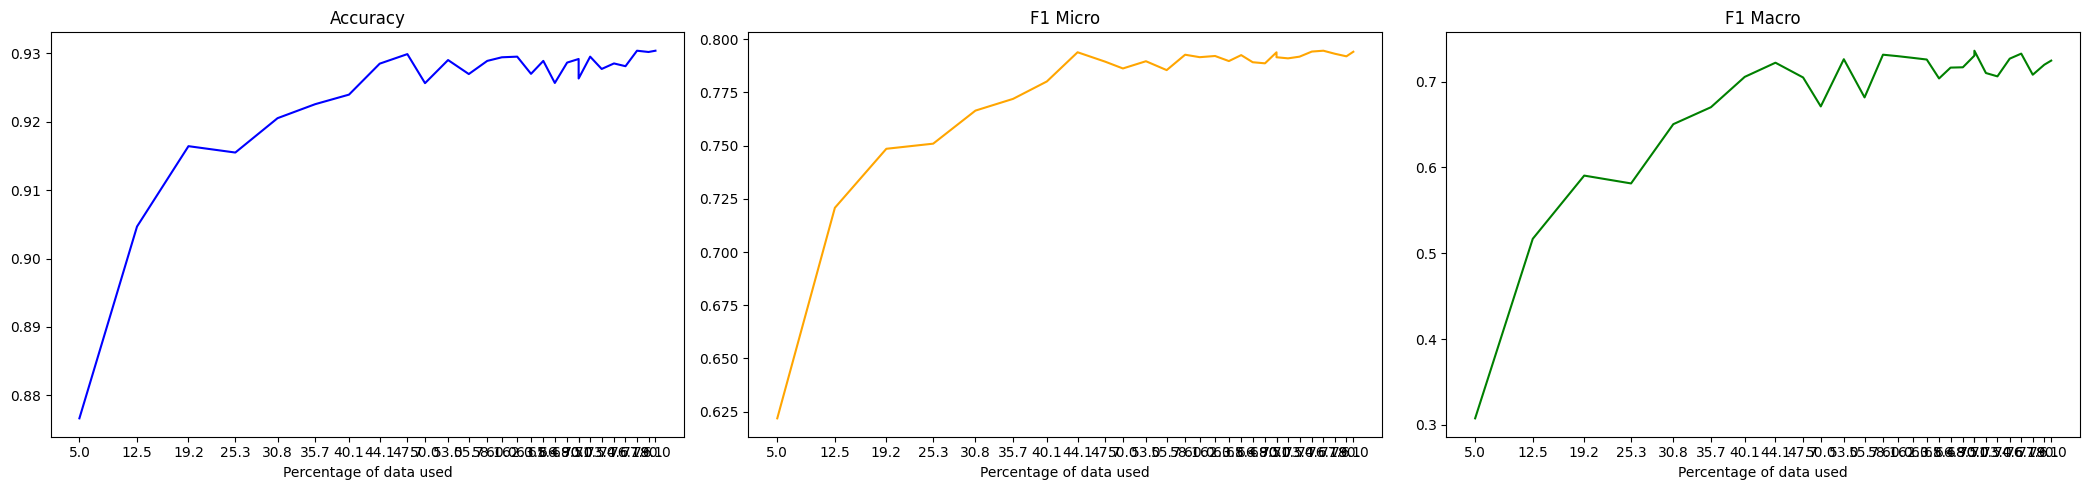

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.8301, F1 Micro: 0.2873, F1 Macro: 0.0657
Epoch 2/10, Train Loss: 0.3962, Accuracy: 0.836, F1 Micro: 0.144, F1 Macro: 0.0516
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8477, F1 Micro: 0.2738, F1 Macro: 0.0968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.342, Accuracy: 0.8656, F1 Micro: 0.4801, F1 Macro: 0.2063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3117, Accuracy: 0.8768, F1 Micro: 0.5736, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2746, Accuracy: 0.88, F1 Micro: 0.5854, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2515, Accuracy: 0.8841, F1 Micro: 0.5877, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2305, Accuracy: 0.8869, F1 Micro: 0.6337, F1 Macro: 0.3399
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2015, Accuracy: 0.8891, F1 Micro: 0.6409, F1 Macro: 0.3499
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4877, Accuracy: 0.83, F1 Micro: 0.3968, F1 Macro: 0.1075
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4147, Accuracy: 0.8531, F1 Micro: 0.4412, F1 Macro: 0.1528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3679, Accuracy: 0.88, F1 Micro: 0.6098, F1 Macro: 0.3087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.328, Accuracy: 0.8912, F1 Micro: 0.6103, F1 Macro: 0.3775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2713, Accuracy: 0.901, F1 Micro: 0.6792, F1 Macro: 0.4544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2296, Accuracy: 0.904, F1 Micro: 0.7006, F1 Macro: 0.4692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1918, Accuracy: 0.9066, F1 Micro: 0.7214, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1499, Accuracy: 0.9087, F1 Micro: 0.7245, F1 Macro: 0.5342
Epoch 9/10, Train Loss: 0.1301, Accuracy: 0.9071, F1 Micro: 0.71

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4655, Accuracy: 0.8251, F1 Micro: 0.4036, F1 Macro: 0.1103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3892, Accuracy: 0.8706, F1 Micro: 0.5365, F1 Macro: 0.2746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.347, Accuracy: 0.8962, F1 Micro: 0.7067, F1 Macro: 0.4881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2902, Accuracy: 0.909, F1 Micro: 0.7168, F1 Macro: 0.4984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2409, Accuracy: 0.9128, F1 Micro: 0.7257, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1964, Accuracy: 0.9087, F1 Micro: 0.728, F1 Macro: 0.5362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1577, Accuracy: 0.9113, F1 Micro: 0.7321, F1 Macro: 0.5439
Epoch 8/10, Train Loss: 0.1317, Accuracy: 0.9119, F1 Micro: 0.7229, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1096, Accuracy: 0.913, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.459, Accuracy: 0.8431, F1 Micro: 0.4462, F1 Macro: 0.151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3873, Accuracy: 0.8879, F1 Micro: 0.5842, F1 Macro: 0.3653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3217, Accuracy: 0.9072, F1 Micro: 0.6881, F1 Macro: 0.484
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2689, Accuracy: 0.9135, F1 Micro: 0.7457, F1 Macro: 0.5469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2083, Accuracy: 0.915, F1 Micro: 0.7462, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1682, Accuracy: 0.9156, F1 Micro: 0.7536, F1 Macro: 0.5894
Epoch 7/10, Train Loss: 0.1322, Accuracy: 0.9164, F1 Micro: 0.7378, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1126, Accuracy: 0.9191, F1 Micro: 0.7561, F1 Macro: 0.5843
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9184, F1 Micro: 0.7553, F1 Macro: 0.6068
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4514, Accuracy: 0.8412, F1 Micro: 0.4653, F1 Macro: 0.1777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3743, Accuracy: 0.8994, F1 Micro: 0.7014, F1 Macro: 0.484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3091, Accuracy: 0.9128, F1 Micro: 0.7302, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2585, Accuracy: 0.9171, F1 Micro: 0.76, F1 Macro: 0.5934
Epoch 5/10, Train Loss: 0.2027, Accuracy: 0.9164, F1 Micro: 0.755, F1 Macro: 0.5845
Epoch 6/10, Train Loss: 0.1623, Accuracy: 0.9195, F1 Micro: 0.7499, F1 Macro: 0.598
Epoch 7/10, Train Loss: 0.1286, Accuracy: 0.9167, F1 Micro: 0.7557, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9193, F1 Micro: 0.7668, F1 Macro: 0.6212
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9155, F1 Micro: 0.7646, F1 Macro: 0.6406
Epoch 10/10, Train Loss: 0.0801, Accuracy: 0.9202, F1 Micro: 0.7608, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4423, Accuracy: 0.8655, F1 Micro: 0.5627, F1 Macro: 0.2762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3548, Accuracy: 0.9101, F1 Micro: 0.7257, F1 Macro: 0.5403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2999, Accuracy: 0.9167, F1 Micro: 0.7377, F1 Macro: 0.5707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2389, Accuracy: 0.9208, F1 Micro: 0.757, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.9209, F1 Micro: 0.7597, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1533, Accuracy: 0.9222, F1 Micro: 0.7634, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9211, F1 Micro: 0.7666, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9236, F1 Micro: 0.7674, F1 Macro: 0.6408
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4385, Accuracy: 0.8751, F1 Micro: 0.6061, F1 Macro: 0.3115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3412, Accuracy: 0.9071, F1 Micro: 0.6822, F1 Macro: 0.4799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2779, Accuracy: 0.9184, F1 Micro: 0.7592, F1 Macro: 0.5969
Epoch 4/10, Train Loss: 0.2246, Accuracy: 0.9209, F1 Micro: 0.7477, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1828, Accuracy: 0.9197, F1 Micro: 0.7656, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9217, F1 Micro: 0.7679, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9227, F1 Micro: 0.772, F1 Macro: 0.6416
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.922, F1 Micro: 0.774, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.922, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4303, Accuracy: 0.8823, F1 Micro: 0.582, F1 Macro: 0.2963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3304, Accuracy: 0.9095, F1 Micro: 0.7349, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2709, Accuracy: 0.9197, F1 Micro: 0.7572, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.9175, F1 Micro: 0.7667, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1764, Accuracy: 0.9218, F1 Micro: 0.7703, F1 Macro: 0.6384
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9223, F1 Micro: 0.775, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1166, Accuracy: 0.9264, F1 Micro: 0.7813, F1 Macro: 0.6713
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9257, F1 Micro: 0.7805, F1 Macro: 0.6816
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9258, F1 Micro: 0.7775, F1 Macro: 0.6952
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4209, Accuracy: 0.8905, F1 Micro: 0.6216, F1 Macro: 0.3728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.9156, F1 Micro: 0.7436, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2646, Accuracy: 0.922, F1 Micro: 0.754, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9258, F1 Micro: 0.7721, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9265, F1 Micro: 0.7804, F1 Macro: 0.6495
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9259, F1 Micro: 0.7796, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9262, F1 Micro: 0.7806, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9244, F1 Micro: 0.7828, F1 Macro: 0.703
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9282, F1 Micro: 0.7816, F1 Macro: 0.7051
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.8922, F1 Micro: 0.6728, F1 Macro: 0.462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3157, Accuracy: 0.9079, F1 Micro: 0.746, F1 Macro: 0.5855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2566, Accuracy: 0.923, F1 Micro: 0.7653, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9248, F1 Micro: 0.7707, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9234, F1 Micro: 0.7812, F1 Macro: 0.6531
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9265, F1 Micro: 0.7732, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9286, F1 Micro: 0.7864, F1 Macro: 0.6925
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9269, F1 Micro: 0.7885, F1 Macro: 0.7138
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9282, F1 Micro: 0.788, F1 Macro: 0.7233
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8979, F1 Micro: 0.6577, F1 Macro: 0.4175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2996, Accuracy: 0.9161, F1 Micro: 0.748, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.246, Accuracy: 0.9227, F1 Micro: 0.7663, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9259, F1 Micro: 0.7817, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9279, F1 Micro: 0.7819, F1 Macro: 0.6678
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9235, F1 Micro: 0.7805, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9258, F1 Micro: 0.7837, F1 Macro: 0.7044
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9235, F1 Micro: 0.7827, F1 Macro: 0.7118
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9288, F1 Micro: 0.79, F1 Macro: 0.7238
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8997, F1 Micro: 0.6529, F1 Macro: 0.404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2992, Accuracy: 0.9167, F1 Micro: 0.737, F1 Macro: 0.5463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9239, F1 Micro: 0.7696, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9235, F1 Micro: 0.7837, F1 Macro: 0.6724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.927, F1 Micro: 0.7859, F1 Macro: 0.6708
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9231, F1 Micro: 0.7844, F1 Macro: 0.6829
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9271, F1 Micro: 0.7762, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9286, F1 Micro: 0.794, F1 Macro: 0.7237
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9285, F1 Micro: 0.7886, F1 Macro: 0.7185
Epoch 10/10, Train Loss: 0.0616, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3936, Accuracy: 0.9018, F1 Micro: 0.6842, F1 Macro: 0.4847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.9178, F1 Micro: 0.7332, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2313, Accuracy: 0.9223, F1 Micro: 0.7764, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9268, F1 Micro: 0.7797, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9269, F1 Micro: 0.7866, F1 Macro: 0.6709
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9269, F1 Micro: 0.7839, F1 Macro: 0.7022
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9267, F1 Micro: 0.7831, F1 Macro: 0.7019
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9259, F1 Micro: 0.7852, F1 Macro: 0.71
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9289, F1 Micro: 0.7888, F1 Macro: 0.7244
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3892, Accuracy: 0.9037, F1 Micro: 0.7028, F1 Macro: 0.4964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2781, Accuracy: 0.9189, F1 Micro: 0.7441, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.925, F1 Micro: 0.7785, F1 Macro: 0.6728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9259, F1 Micro: 0.7816, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9286, F1 Micro: 0.7872, F1 Macro: 0.6959
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9256, F1 Micro: 0.7835, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9267, F1 Micro: 0.7876, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9249, F1 Micro: 0.7887, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9301, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.9048, F1 Micro: 0.7012, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.9154, F1 Micro: 0.7546, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9212, F1 Micro: 0.7753, F1 Macro: 0.6401
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9168, F1 Micro: 0.7721, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9284, F1 Micro: 0.7834, F1 Macro: 0.6825
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9281, F1 Micro: 0.7816, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9257, F1 Micro: 0.7846, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.929, F1 Micro: 0.7873, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9268, F1 Micro: 0.7929, F1 Macro: 0.7318
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.9053, F1 Micro: 0.7144, F1 Macro: 0.5138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.9206, F1 Micro: 0.7655, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.925, F1 Micro: 0.7707, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9252, F1 Micro: 0.7828, F1 Macro: 0.6636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9289, F1 Micro: 0.7921, F1 Macro: 0.6742
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9297, F1 Micro: 0.7919, F1 Macro: 0.6926
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9274, F1 Micro: 0.7903, F1 Macro: 0.7205
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9267, F1 Micro: 0.7843, F1 Macro: 0.7116
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9289, F1 Micro: 0.7889, F1 Macro: 0.7218
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9302, F1 Micro: 0.7889, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.902, F1 Micro: 0.6827, F1 Macro: 0.4363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9193, F1 Micro: 0.7499, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9241, F1 Micro: 0.7592, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9274, F1 Micro: 0.7872, F1 Macro: 0.6513
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9289, F1 Micro: 0.7838, F1 Macro: 0.6896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.9275, F1 Micro: 0.7888, F1 Macro: 0.7041
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9278, F1 Micro: 0.7916, F1 Macro: 0.7192
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9256, F1 Micro: 0.785, F1 Macro: 0.7142
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9261, F1 Micro: 0.7908, F1 Macro: 0.7216
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.9081, F1 Micro: 0.7149, F1 Macro: 0.4997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9149, F1 Micro: 0.7596, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9249, F1 Micro: 0.7773, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9265, F1 Micro: 0.7794, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9273, F1 Micro: 0.7909, F1 Macro: 0.6813
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9274, F1 Micro: 0.7897, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9274, F1 Micro: 0.7918, F1 Macro: 0.7227
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9275, F1 Micro: 0.7904, F1 Macro: 0.7214
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9299, F1 Micro: 0.7895, F1 Macro: 0.72
Epoch 10/10, Train Loss: 0.0473, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3622, Accuracy: 0.9052, F1 Micro: 0.7191, F1 Macro: 0.488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9188, F1 Micro: 0.7526, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9245, F1 Micro: 0.7743, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9228, F1 Micro: 0.7815, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9278, F1 Micro: 0.7884, F1 Macro: 0.6718
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9231, F1 Micro: 0.7863, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9279, F1 Micro: 0.7899, F1 Macro: 0.7147
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9278, F1 Micro: 0.7883, F1 Macro: 0.7067
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9263, F1 Micro: 0.7863, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.9052, F1 Micro: 0.6836, F1 Macro: 0.4406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9192, F1 Micro: 0.764, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1941, Accuracy: 0.9282, F1 Micro: 0.7802, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9251, F1 Micro: 0.7858, F1 Macro: 0.6585
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9244, F1 Micro: 0.7847, F1 Macro: 0.6827
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9268, F1 Micro: 0.7867, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9312, F1 Micro: 0.7899, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.928, F1 Micro: 0.7912, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9283, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3597, Accuracy: 0.907, F1 Micro: 0.6971, F1 Macro: 0.4771
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.9202, F1 Micro: 0.7629, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9236, F1 Micro: 0.778, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9242, F1 Micro: 0.7836, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9272, F1 Micro: 0.7871, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9282, F1 Micro: 0.7917, F1 Macro: 0.7117
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.927, F1 Micro: 0.7896, F1 Macro: 0.7216
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9273, F1 Micro: 0.7862, F1 Macro: 0.7133
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9297, F1 Micro: 0.7943, F1 Macro: 0.7296
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3507, Accuracy: 0.908, F1 Micro: 0.7133, F1 Macro: 0.4691
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9195, F1 Micro: 0.7457, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9243, F1 Micro: 0.7717, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9248, F1 Micro: 0.7819, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9249, F1 Micro: 0.7829, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9258, F1 Micro: 0.7872, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9291, F1 Micro: 0.7881, F1 Macro: 0.7222
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9296, F1 Micro: 0.7889, F1 Macro: 0.7151
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9228, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3479, Accuracy: 0.9084, F1 Micro: 0.7069, F1 Macro: 0.4848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9175, F1 Micro: 0.7631, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9212, F1 Micro: 0.7743, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.929, F1 Micro: 0.7799, F1 Macro: 0.6684
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9283, F1 Micro: 0.779, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9288, F1 Micro: 0.7917, F1 Macro: 0.7117
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9274, F1 Micro: 0.7913, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.929, F1 Micro: 0.7945, F1 Macro: 0.7286
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9273, F1 Micro: 0.7896, F1 Macro: 0.719
Epoch 10/10, Train Loss: 0.0447, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3483, Accuracy: 0.9083, F1 Micro: 0.7181, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.9184, F1 Micro: 0.7693, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9236, F1 Micro: 0.771, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9243, F1 Micro: 0.7833, F1 Macro: 0.6661
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9275, F1 Micro: 0.7828, F1 Macro: 0.688
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9286, F1 Micro: 0.7823, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9299, F1 Micro: 0.7912, F1 Macro: 0.7163
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9317, F1 Micro: 0.7989, F1 Macro: 0.7268
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9274, F1 Micro: 0.7935, F1 Macro: 0.7363
Epoch 10/10, Train Loss: 0.0442, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3361, Accuracy: 0.8991, F1 Micro: 0.721, F1 Macro: 0.5343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.92, F1 Micro: 0.7533, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9262, F1 Micro: 0.7833, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9255, F1 Micro: 0.785, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9274, F1 Micro: 0.786, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9294, F1 Micro: 0.7919, F1 Macro: 0.7075
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9278, F1 Micro: 0.7913, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.929, F1 Micro: 0.7926, F1 Macro: 0.7248
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9264, F1 Micro: 0.7875, F1 Macro: 0.7242
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.332, Accuracy: 0.9037, F1 Micro: 0.6719, F1 Macro: 0.4451
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9213, F1 Micro: 0.7655, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9249, F1 Micro: 0.7682, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9289, F1 Micro: 0.783, F1 Macro: 0.6712
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9278, F1 Micro: 0.7779, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9284, F1 Micro: 0.7945, F1 Macro: 0.7086
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9295, F1 Micro: 0.7884, F1 Macro: 0.71
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.929, F1 Micro: 0.7946, F1 Macro: 0.724
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9306, F1 Micro: 0.7946, F1 Macro: 0.7262
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3249, Accuracy: 0.9069, F1 Micro: 0.721, F1 Macro: 0.4907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.9208, F1 Micro: 0.7577, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.926, F1 Micro: 0.7715, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.9289, F1 Micro: 0.7911, F1 Macro: 0.6749
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9275, F1 Micro: 0.7823, F1 Macro: 0.6533
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9271, F1 Micro: 0.7893, F1 Macro: 0.7071
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9284, F1 Micro: 0.7878, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.931, F1 Micro: 0.7959, F1 Macro: 0.7211
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9275, F1 Micro: 0.7919, F1 Macro: 0.7273
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.927, F1 Micro: 0.7956, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3227, Accuracy: 0.9037, F1 Micro: 0.7074, F1 Macro: 0.4578
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2174, Accuracy: 0.9218, F1 Micro: 0.7582, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9265, F1 Micro: 0.7791, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9258, F1 Micro: 0.7863, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9271, F1 Micro: 0.7877, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9308, F1 Micro: 0.7941, F1 Macro: 0.6916
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9281, F1 Micro: 0.7903, F1 Macro: 0.7135
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9264, F1 Micro: 0.7901, F1 Macro: 0.7182
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9235, F1 Micro: 0.7856, F1 Macro: 0.7179
Epoch 10/10, Train Loss: 0.0441, Accur

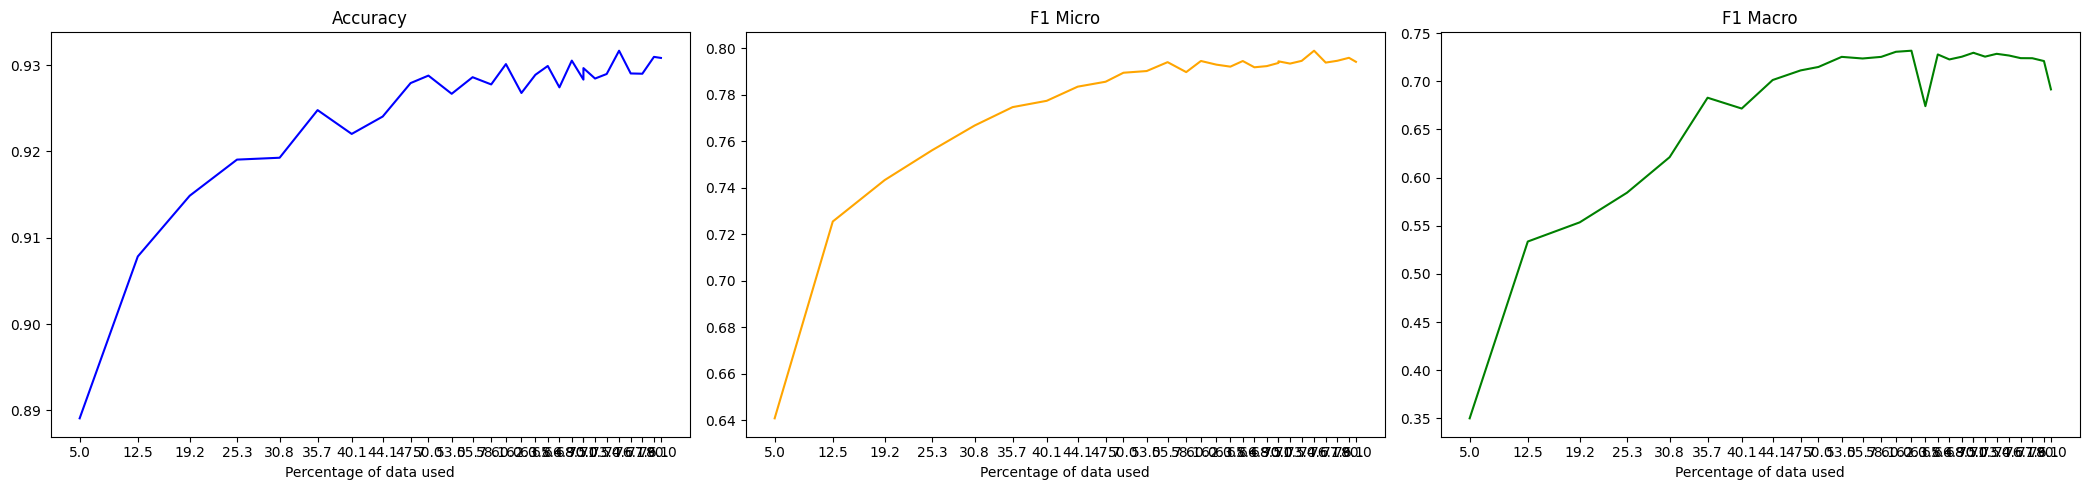

In [23]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.8293, F1 Micro: 0.063, F1 Macro: 0.0218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.8417, F1 Micro: 0.2125, F1 Macro: 0.0699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.389, Accuracy: 0.8438, F1 Micro: 0.2285, F1 Macro: 0.0804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3539, Accuracy: 0.8604, F1 Micro: 0.4052, F1 Macro: 0.1597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8723, F1 Micro: 0.5143, F1 Macro: 0.2487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2817, Accuracy: 0.8774, F1 Micro: 0.5561, F1 Macro: 0.2819
Epoch 7/10, Train Loss: 0.2562, Accuracy: 0.8755, F1 Micro: 0.5114, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2286, Accuracy: 0.884, F1 Micro: 0.5828, F1 Macro: 0.3379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.204, Accuracy: 0.8891, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4868, Accuracy: 0.8415, F1 Micro: 0.395, F1 Macro: 0.1113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4106, Accuracy: 0.8534, F1 Micro: 0.3962, F1 Macro: 0.1285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3705, Accuracy: 0.8889, F1 Micro: 0.6332, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3101, Accuracy: 0.8983, F1 Micro: 0.6977, F1 Macro: 0.4722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2578, Accuracy: 0.9023, F1 Micro: 0.7035, F1 Macro: 0.5231
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2172, Accuracy: 0.9032, F1 Micro: 0.7247, F1 Macro: 0.5538
Epoch 7/10, Train Loss: 0.184, Accuracy: 0.906, F1 Micro: 0.71, F1 Macro: 0.5478
Epoch 8/10, Train Loss: 0.146, Accuracy: 0.9074, F1 Micro: 0.7206, F1 Macro: 0.5515
Epoch 9/10, Train Loss: 0.1333, Accuracy: 0.9028, F1 Micro: 0.7156, F1 Macro: 0.5602
Epoch 10/10, Train Loss: 0.1107, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4668, Accuracy: 0.8322, F1 Micro: 0.395, F1 Macro: 0.1085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.386, Accuracy: 0.8696, F1 Micro: 0.5359, F1 Macro: 0.2802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3445, Accuracy: 0.9002, F1 Micro: 0.6799, F1 Macro: 0.4845
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2838, Accuracy: 0.9089, F1 Micro: 0.7196, F1 Macro: 0.5223
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2264, Accuracy: 0.9095, F1 Micro: 0.7335, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.19, Accuracy: 0.9113, F1 Micro: 0.7415, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1479, Accuracy: 0.911, F1 Micro: 0.7462, F1 Macro: 0.5801
Epoch 8/10, Train Loss: 0.1232, Accuracy: 0.9158, F1 Micro: 0.7411, F1 Macro: 0.5699
Epoch 9/10, Train Loss: 0.1054, Accuracy: 0.9134, F1 Micro: 0.7433, F1 Macro: 0.5915
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4489, Accuracy: 0.8379, F1 Micro: 0.4058, F1 Macro: 0.1156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3774, Accuracy: 0.8828, F1 Micro: 0.5475, F1 Macro: 0.301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3149, Accuracy: 0.9068, F1 Micro: 0.7096, F1 Macro: 0.5074
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2584, Accuracy: 0.9144, F1 Micro: 0.7318, F1 Macro: 0.5597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2058, Accuracy: 0.9159, F1 Micro: 0.7425, F1 Macro: 0.5782
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.912, F1 Micro: 0.7289, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1334, Accuracy: 0.914, F1 Micro: 0.7436, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9142, F1 Micro: 0.7558, F1 Macro: 0.6187
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.9177, F1 Micro: 0.7537, F1 Macro: 0.6271
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4436, Accuracy: 0.8455, F1 Micro: 0.4346, F1 Macro: 0.1207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3564, Accuracy: 0.8967, F1 Micro: 0.6455, F1 Macro: 0.3876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.299, Accuracy: 0.9139, F1 Micro: 0.7373, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2476, Accuracy: 0.9182, F1 Micro: 0.7524, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1978, Accuracy: 0.9196, F1 Micro: 0.7638, F1 Macro: 0.607
Epoch 6/10, Train Loss: 0.1552, Accuracy: 0.9192, F1 Micro: 0.7616, F1 Macro: 0.6215
Epoch 7/10, Train Loss: 0.1255, Accuracy: 0.9178, F1 Micro: 0.7616, F1 Macro: 0.6315
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9216, F1 Micro: 0.762, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.088, Accuracy: 0.92, F1 Micro: 0.7654, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4398, Accuracy: 0.8677, F1 Micro: 0.5354, F1 Macro: 0.2284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3501, Accuracy: 0.9048, F1 Micro: 0.7093, F1 Macro: 0.5313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2865, Accuracy: 0.9128, F1 Micro: 0.7176, F1 Macro: 0.5422
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2395, Accuracy: 0.9171, F1 Micro: 0.7563, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1825, Accuracy: 0.9185, F1 Micro: 0.7566, F1 Macro: 0.6178
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1512, Accuracy: 0.917, F1 Micro: 0.7647, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9234, F1 Micro: 0.7714, F1 Macro: 0.65
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9218, F1 Micro: 0.7675, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9241, F1 Micro: 0.7699, F1 Macro: 0.6621
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8839, F1 Micro: 0.5764, F1 Macro: 0.3184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3393, Accuracy: 0.9071, F1 Micro: 0.7201, F1 Macro: 0.5177
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2782, Accuracy: 0.9174, F1 Micro: 0.7526, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2232, Accuracy: 0.9236, F1 Micro: 0.7684, F1 Macro: 0.616
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.922, F1 Micro: 0.7632, F1 Macro: 0.6272
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9236, F1 Micro: 0.7646, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9236, F1 Micro: 0.7768, F1 Macro: 0.6672
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9223, F1 Micro: 0.7733, F1 Macro: 0.6777
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.924, F1 Micro: 0.7742, F1 Macro: 0.6897
Epoch 10/10, Train Loss: 0.0697, Accuracy: 0.924, F1 Micro: 0.7757, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.8894, F1 Micro: 0.6278, F1 Macro: 0.3594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3324, Accuracy: 0.9112, F1 Micro: 0.7359, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2647, Accuracy: 0.9213, F1 Micro: 0.7647, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2231, Accuracy: 0.9258, F1 Micro: 0.7745, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9257, F1 Micro: 0.7763, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9235, F1 Micro: 0.7771, F1 Macro: 0.6716
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9246, F1 Micro: 0.7756, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9254, F1 Micro: 0.7845, F1 Macro: 0.6929
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9254, F1 Micro: 0.7772, F1 Macro: 0.7072
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4204, Accuracy: 0.8944, F1 Micro: 0.6309, F1 Macro: 0.4193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3201, Accuracy: 0.9156, F1 Micro: 0.737, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.256, Accuracy: 0.9229, F1 Micro: 0.7548, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2014, Accuracy: 0.922, F1 Micro: 0.7773, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9247, F1 Micro: 0.7837, F1 Macro: 0.669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9281, F1 Micro: 0.7868, F1 Macro: 0.6852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9268, F1 Micro: 0.7883, F1 Macro: 0.6972
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9277, F1 Micro: 0.7855, F1 Macro: 0.7125
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.9243, F1 Micro: 0.7788, F1 Macro: 0.7007
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4124, Accuracy: 0.8949, F1 Micro: 0.6418, F1 Macro: 0.3695
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.31, Accuracy: 0.9178, F1 Micro: 0.7449, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2511, Accuracy: 0.9177, F1 Micro: 0.7663, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2042, Accuracy: 0.9252, F1 Micro: 0.7676, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9257, F1 Micro: 0.7813, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.926, F1 Micro: 0.7853, F1 Macro: 0.683
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9269, F1 Micro: 0.7754, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9279, F1 Micro: 0.7866, F1 Macro: 0.7085
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.928, F1 Micro: 0.7835, F1 Macro: 0.7122
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4081, Accuracy: 0.8991, F1 Micro: 0.665, F1 Macro: 0.4233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3043, Accuracy: 0.9195, F1 Micro: 0.7507, F1 Macro: 0.5931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.9255, F1 Micro: 0.7801, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9257, F1 Micro: 0.7848, F1 Macro: 0.6826
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9262, F1 Micro: 0.7835, F1 Macro: 0.6868
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9261, F1 Micro: 0.7873, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9278, F1 Micro: 0.7888, F1 Macro: 0.6999
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9262, F1 Micro: 0.7822, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9279, F1 Micro: 0.7901, F1 Macro: 0.7192
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8999, F1 Micro: 0.688, F1 Macro: 0.4411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.9189, F1 Micro: 0.7415, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.9239, F1 Micro: 0.7683, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9258, F1 Micro: 0.7809, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9266, F1 Micro: 0.7872, F1 Macro: 0.6825
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9237, F1 Micro: 0.7817, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9287, F1 Micro: 0.7875, F1 Macro: 0.6898
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9271, F1 Micro: 0.7875, F1 Macro: 0.7223
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9286, F1 Micro: 0.7882, F1 Macro: 0.7174
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8987, F1 Micro: 0.6434, F1 Macro: 0.4411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.9205, F1 Micro: 0.7605, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2317, Accuracy: 0.9191, F1 Micro: 0.777, F1 Macro: 0.6391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9241, F1 Micro: 0.785, F1 Macro: 0.6626
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.925, F1 Micro: 0.7812, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9291, F1 Micro: 0.7852, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9291, F1 Micro: 0.7915, F1 Macro: 0.7161
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9292, F1 Micro: 0.7869, F1 Macro: 0.7149
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.9285, F1 Micro: 0.7859, F1 Macro: 0.7097
Epoch 10/10, Train Loss: 0.0539, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3885, Accuracy: 0.9049, F1 Micro: 0.6933, F1 Macro: 0.5028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.9166, F1 Micro: 0.7271, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.9242, F1 Micro: 0.7721, F1 Macro: 0.627
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9248, F1 Micro: 0.7652, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9235, F1 Micro: 0.7757, F1 Macro: 0.6811
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9197, F1 Micro: 0.7744, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.927, F1 Micro: 0.789, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9292, F1 Micro: 0.7911, F1 Macro: 0.7109
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.9276, F1 Micro: 0.7873, F1 Macro: 0.7193
Epoch 10/10, Train Loss: 0.0518, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3811, Accuracy: 0.9045, F1 Micro: 0.7024, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2705, Accuracy: 0.9189, F1 Micro: 0.7485, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9261, F1 Micro: 0.7739, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9257, F1 Micro: 0.78, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9273, F1 Micro: 0.7877, F1 Macro: 0.6715
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9284, F1 Micro: 0.7861, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9297, F1 Micro: 0.7903, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.928, F1 Micro: 0.7905, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9301, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3748, Accuracy: 0.9045, F1 Micro: 0.6773, F1 Macro: 0.4584
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.9178, F1 Micro: 0.7638, F1 Macro: 0.5958
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.9258, F1 Micro: 0.7637, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.924, F1 Micro: 0.783, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9254, F1 Micro: 0.7856, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.9264, F1 Micro: 0.7872, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9268, F1 Micro: 0.7913, F1 Macro: 0.7144
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9286, F1 Micro: 0.7872, F1 Macro: 0.7017
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9291, F1 Micro: 0.7944, F1 Macro: 0.7245
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.9047, F1 Micro: 0.7057, F1 Macro: 0.4402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9191, F1 Micro: 0.7629, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9195, F1 Micro: 0.7759, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9266, F1 Micro: 0.7804, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.929, F1 Micro: 0.79, F1 Macro: 0.677
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9247, F1 Micro: 0.784, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.928, F1 Micro: 0.7942, F1 Macro: 0.7219
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9273, F1 Micro: 0.788, F1 Macro: 0.7099
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9276, F1 Micro: 0.7891, F1 Macro: 0.7171
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3659, Accuracy: 0.9057, F1 Micro: 0.7123, F1 Macro: 0.4961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.9202, F1 Micro: 0.7609, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9249, F1 Micro: 0.7675, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9288, F1 Micro: 0.7898, F1 Macro: 0.6725
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9282, F1 Micro: 0.7784, F1 Macro: 0.6815
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9249, F1 Micro: 0.7882, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9294, F1 Micro: 0.7945, F1 Macro: 0.7155
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9272, F1 Micro: 0.7765, F1 Macro: 0.6984
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9248, F1 Micro: 0.7842, F1 Macro: 0.7191
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.9273, F1 Micro: 0.788, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3655, Accuracy: 0.9076, F1 Micro: 0.7118, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.9217, F1 Micro: 0.7552, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.924, F1 Micro: 0.7831, F1 Macro: 0.6343
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9265, F1 Micro: 0.7827, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9258, F1 Micro: 0.7847, F1 Macro: 0.6818
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9281, F1 Micro: 0.7829, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9254, F1 Micro: 0.7905, F1 Macro: 0.7134
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9243, F1 Micro: 0.7877, F1 Macro: 0.7165
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9274, F1 Micro: 0.786, F1 Macro: 0.7156
Epoch 10/10, Train Loss: 0.0482, Accuracy: 0.93, F1 Micro: 0.7896, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3545, Accuracy: 0.9016, F1 Micro: 0.7163, F1 Macro: 0.5223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.92, F1 Micro: 0.7559, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9248, F1 Micro: 0.7757, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9269, F1 Micro: 0.7816, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9247, F1 Micro: 0.7838, F1 Macro: 0.6747
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9293, F1 Micro: 0.7785, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.929, F1 Micro: 0.7925, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9298, F1 Micro: 0.7866, F1 Macro: 0.708
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.926, F1 Micro: 0.7921, F1 Macro: 0.7289
Epoch 10/10, Train Loss: 0.0515, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3528, Accuracy: 0.9072, F1 Micro: 0.7015, F1 Macro: 0.4726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.9203, F1 Micro: 0.7524, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9256, F1 Micro: 0.7837, F1 Macro: 0.6578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9246, F1 Micro: 0.7871, F1 Macro: 0.672
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9267, F1 Micro: 0.7756, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9286, F1 Micro: 0.7907, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9285, F1 Micro: 0.7932, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9256, F1 Micro: 0.7873, F1 Macro: 0.7088
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9277, F1 Micro: 0.7907, F1 Macro: 0.721
Epoch 10/10, Train Loss: 0.0472, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.9049, F1 Micro: 0.6907, F1 Macro: 0.4687
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2423, Accuracy: 0.9204, F1 Micro: 0.7653, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9262, F1 Micro: 0.7764, F1 Macro: 0.6224
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9242, F1 Micro: 0.7605, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.927, F1 Micro: 0.7852, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9302, F1 Micro: 0.788, F1 Macro: 0.7062
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9254, F1 Micro: 0.7878, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9287, F1 Micro: 0.7915, F1 Macro: 0.7242
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9253, F1 Micro: 0.7852, F1 Macro: 0.7125
Epoch 10/10, Train Loss: 0.047, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3437, Accuracy: 0.9058, F1 Micro: 0.7077, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9204, F1 Micro: 0.7624, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9253, F1 Micro: 0.7723, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9282, F1 Micro: 0.7879, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9295, F1 Micro: 0.7898, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9308, F1 Micro: 0.7932, F1 Macro: 0.7019
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9305, F1 Micro: 0.7932, F1 Macro: 0.7138
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9281, F1 Micro: 0.789, F1 Macro: 0.7105
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9242, F1 Micro: 0.7861, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3423, Accuracy: 0.9058, F1 Micro: 0.6997, F1 Macro: 0.4605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.9209, F1 Micro: 0.7613, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.927, F1 Micro: 0.7858, F1 Macro: 0.6637
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.926, F1 Micro: 0.7853, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9308, F1 Micro: 0.792, F1 Macro: 0.7013
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.927, F1 Micro: 0.7894, F1 Macro: 0.7095
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9286, F1 Micro: 0.7864, F1 Macro: 0.7103
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.928, F1 Micro: 0.7841, F1 Macro: 0.7101
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9274, F1 Micro: 0.7922, F1 Macro: 0.72
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9288, F1 Micro: 0.7891, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3343, Accuracy: 0.9063, F1 Micro: 0.6912, F1 Macro: 0.4949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9184, F1 Micro: 0.7648, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9247, F1 Micro: 0.7781, F1 Macro: 0.6227
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9189, F1 Micro: 0.7745, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9271, F1 Micro: 0.785, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9288, F1 Micro: 0.7908, F1 Macro: 0.7083
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9246, F1 Micro: 0.7806, F1 Macro: 0.7054
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.927, F1 Micro: 0.7808, F1 Macro: 0.7151
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9275, F1 Micro: 0.7904, F1 Macro: 0.726
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.927, F1 Micro: 0.7866, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3251, Accuracy: 0.9062, F1 Micro: 0.7276, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2228, Accuracy: 0.9208, F1 Micro: 0.7528, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9255, F1 Micro: 0.7804, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9286, F1 Micro: 0.7814, F1 Macro: 0.6728
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9251, F1 Micro: 0.7791, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9262, F1 Micro: 0.7832, F1 Macro: 0.7093
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9272, F1 Micro: 0.7828, F1 Macro: 0.712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9298, F1 Micro: 0.7923, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9272, F1 Micro: 0.7895, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3225, Accuracy: 0.9089, F1 Micro: 0.7171, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.9214, F1 Micro: 0.757, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9263, F1 Micro: 0.7786, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9256, F1 Micro: 0.7831, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9278, F1 Micro: 0.7848, F1 Macro: 0.6823
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9236, F1 Micro: 0.7838, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.929, F1 Micro: 0.7935, F1 Macro: 0.7224
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9246, F1 Micro: 0.7883, F1 Macro: 0.7158
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9268, F1 Micro: 0.7876, F1 Macro: 0.7171
Epoch 10/10, Train Loss: 0.0433, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3218, Accuracy: 0.906, F1 Micro: 0.7189, F1 Macro: 0.5118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.9191, F1 Micro: 0.7668, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9257, F1 Micro: 0.7741, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9266, F1 Micro: 0.7826, F1 Macro: 0.6564
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9235, F1 Micro: 0.7787, F1 Macro: 0.6484
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9281, F1 Micro: 0.7801, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9263, F1 Micro: 0.787, F1 Macro: 0.7115
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9266, F1 Micro: 0.7828, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9301, F1 Micro: 0.7956, F1 Macro: 0.7337
Epoch 10/10, Train Loss: 0.0423, Accurac

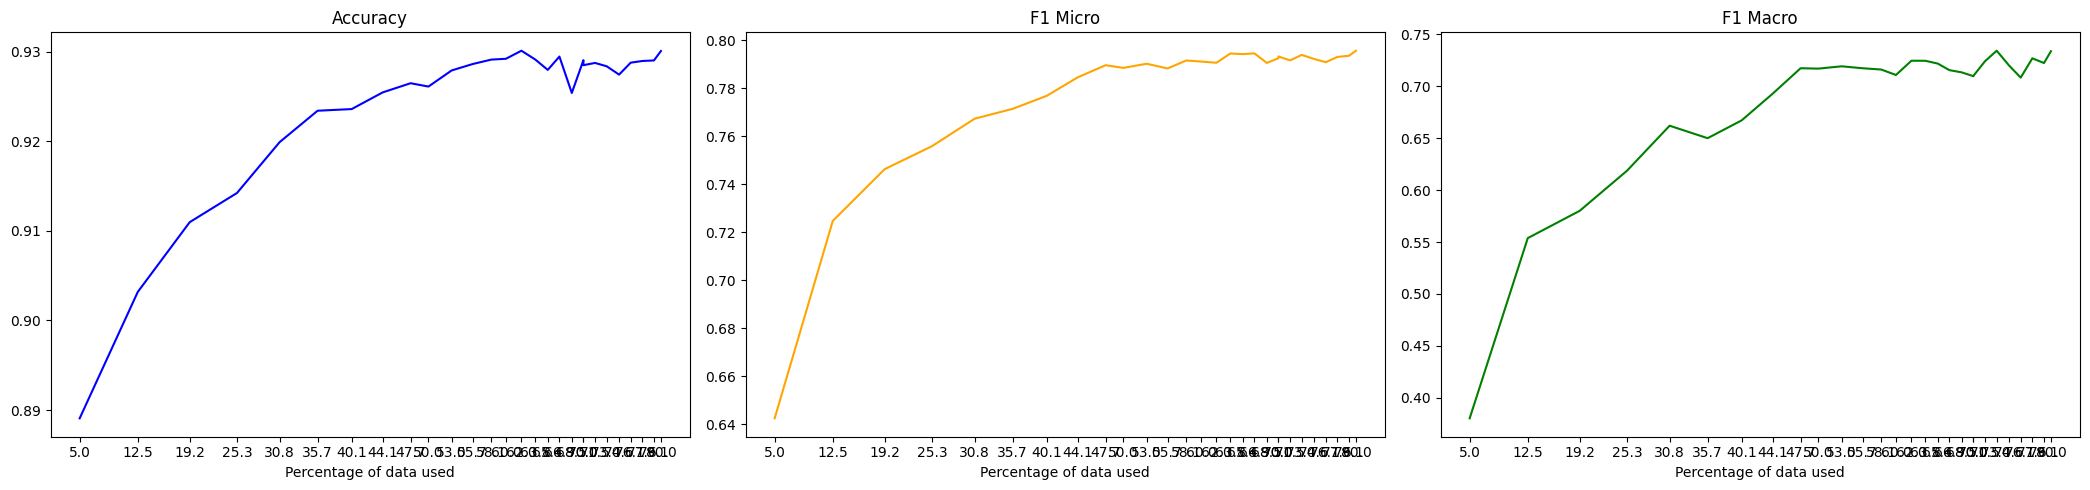

In [24]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8279, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.8342, F1 Micro: 0.1125, F1 Macro: 0.0406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.372, Accuracy: 0.844, F1 Micro: 0.2472, F1 Macro: 0.0837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.8621, F1 Micro: 0.468, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3382, Accuracy: 0.8729, F1 Micro: 0.5892, F1 Macro: 0.2711
Epoch 6/10, Train Loss: 0.2935, Accuracy: 0.8774, F1 Micro: 0.5687, F1 Macro: 0.2658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2645, Accuracy: 0.8822, F1 Micro: 0.6084, F1 Macro: 0.293
Epoch 8/10, Train Loss: 0.2436, Accuracy: 0.8842, F1 Micro: 0.6042, F1 Macro: 0.3032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2213, Accuracy: 0.8868, F1 Micro: 0.6313, F1 Macro: 0.3455
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4872, Accuracy: 0.8268, F1 Micro: 0.3931, F1 Macro: 0.1066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4043, Accuracy: 0.8552, F1 Micro: 0.4708, F1 Macro: 0.1797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3713, Accuracy: 0.8771, F1 Micro: 0.53, F1 Macro: 0.2452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3198, Accuracy: 0.8923, F1 Micro: 0.6545, F1 Macro: 0.3641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2687, Accuracy: 0.8974, F1 Micro: 0.6715, F1 Macro: 0.4546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2302, Accuracy: 0.9011, F1 Micro: 0.6961, F1 Macro: 0.4367
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1951, Accuracy: 0.9034, F1 Micro: 0.7049, F1 Macro: 0.4998
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1606, Accuracy: 0.9027, F1 Micro: 0.7106, F1 Macro: 0.5032
Epoch 9/10, Train Loss: 0.1352, Accuracy: 0.9062, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4723, Accuracy: 0.8313, F1 Micro: 0.4227, F1 Macro: 0.1375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3924, Accuracy: 0.8701, F1 Micro: 0.5993, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3504, Accuracy: 0.8977, F1 Micro: 0.679, F1 Macro: 0.3975
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2833, Accuracy: 0.9018, F1 Micro: 0.7231, F1 Macro: 0.509
Epoch 5/10, Train Loss: 0.238, Accuracy: 0.9088, F1 Micro: 0.7227, F1 Macro: 0.5085
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1855, Accuracy: 0.9076, F1 Micro: 0.7351, F1 Macro: 0.5402
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9117, F1 Micro: 0.7343, F1 Macro: 0.5437
Epoch 8/10, Train Loss: 0.1259, Accuracy: 0.9123, F1 Micro: 0.7273, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1075, Accuracy: 0.9116, F1 Micro: 0.7404, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4592, Accuracy: 0.8409, F1 Micro: 0.436, F1 Macro: 0.1565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3831, Accuracy: 0.8874, F1 Micro: 0.6096, F1 Macro: 0.3171
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3265, Accuracy: 0.9057, F1 Micro: 0.7098, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2625, Accuracy: 0.9112, F1 Micro: 0.7231, F1 Macro: 0.5123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2099, Accuracy: 0.9131, F1 Micro: 0.7465, F1 Macro: 0.552
Epoch 6/10, Train Loss: 0.1655, Accuracy: 0.9167, F1 Micro: 0.7457, F1 Macro: 0.5859
Epoch 7/10, Train Loss: 0.1361, Accuracy: 0.9162, F1 Micro: 0.7441, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9202, F1 Micro: 0.7524, F1 Macro: 0.6016
Epoch 9/10, Train Loss: 0.1003, Accuracy: 0.9194, F1 Micro: 0.75, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4519, Accuracy: 0.8491, F1 Micro: 0.4554, F1 Macro: 0.1534
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3738, Accuracy: 0.8955, F1 Micro: 0.6907, F1 Macro: 0.4648
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3121, Accuracy: 0.9136, F1 Micro: 0.7314, F1 Macro: 0.5309
Epoch 4/10, Train Loss: 0.2531, Accuracy: 0.9133, F1 Micro: 0.7216, F1 Macro: 0.506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2008, Accuracy: 0.9201, F1 Micro: 0.7597, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9218, F1 Micro: 0.7653, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9211, F1 Micro: 0.7666, F1 Macro: 0.6578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9211, F1 Micro: 0.7707, F1 Macro: 0.6525
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.9171, F1 Micro: 0.765, F1 Macro: 0.6581
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.8603, F1 Micro: 0.5444, F1 Macro: 0.2445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3623, Accuracy: 0.9016, F1 Micro: 0.6856, F1 Macro: 0.4923
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.302, Accuracy: 0.9169, F1 Micro: 0.7387, F1 Macro: 0.5428
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2433, Accuracy: 0.9178, F1 Micro: 0.7502, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1911, Accuracy: 0.9208, F1 Micro: 0.7644, F1 Macro: 0.6213
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9165, F1 Micro: 0.7611, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.925, F1 Micro: 0.7756, F1 Macro: 0.6516
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9227, F1 Micro: 0.7711, F1 Macro: 0.6516
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9236, F1 Micro: 0.7707, F1 Macro: 0.6868
Epoch 10/10, Train Loss: 0.0719, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.8786, F1 Micro: 0.6013, F1 Macro: 0.3119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3529, Accuracy: 0.909, F1 Micro: 0.714, F1 Macro: 0.4809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2842, Accuracy: 0.9172, F1 Micro: 0.7558, F1 Macro: 0.5981
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.921, F1 Micro: 0.7433, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1849, Accuracy: 0.9217, F1 Micro: 0.7672, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.925, F1 Micro: 0.775, F1 Macro: 0.6749
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9246, F1 Micro: 0.769, F1 Macro: 0.6655
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9211, F1 Micro: 0.7748, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9272, F1 Micro: 0.7801, F1 Macro: 0.7059
Epoch 10/10, Train Loss: 0.0718, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4368, Accuracy: 0.8851, F1 Micro: 0.5949, F1 Macro: 0.3194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3308, Accuracy: 0.9092, F1 Micro: 0.6954, F1 Macro: 0.5242
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2774, Accuracy: 0.9194, F1 Micro: 0.7656, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2214, Accuracy: 0.9196, F1 Micro: 0.7734, F1 Macro: 0.66
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1728, Accuracy: 0.9274, F1 Micro: 0.7808, F1 Macro: 0.6633
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9264, F1 Micro: 0.7729, F1 Macro: 0.6952
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9248, F1 Micro: 0.7762, F1 Macro: 0.6976
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9257, F1 Micro: 0.7796, F1 Macro: 0.6949
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.926, F1 Micro: 0.7727, F1 Macro: 0.7108
Epoch 10/10, Train Loss: 0.0652, Accuracy: 0.9271, F1 Micro: 0.7774, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4279, Accuracy: 0.8776, F1 Micro: 0.495, F1 Macro: 0.2847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3239, Accuracy: 0.9154, F1 Micro: 0.73, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2576, Accuracy: 0.9202, F1 Micro: 0.7664, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2095, Accuracy: 0.9223, F1 Micro: 0.7724, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9252, F1 Micro: 0.7727, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9199, F1 Micro: 0.7791, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9276, F1 Micro: 0.7832, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9278, F1 Micro: 0.784, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4245, Accuracy: 0.8963, F1 Micro: 0.6735, F1 Macro: 0.4382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3144, Accuracy: 0.9172, F1 Micro: 0.7357, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.9235, F1 Micro: 0.7641, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.929, F1 Micro: 0.7775, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9257, F1 Micro: 0.7875, F1 Macro: 0.6926
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9228, F1 Micro: 0.7792, F1 Macro: 0.7039
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9246, F1 Micro: 0.7819, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9294, F1 Micro: 0.7892, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9267, F1 Micro: 0.7876, F1 Macro: 0.7123
Epoch 10/10, Train Loss: 0.0628, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4131, Accuracy: 0.8981, F1 Micro: 0.6549, F1 Macro: 0.421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3072, Accuracy: 0.9171, F1 Micro: 0.7424, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9262, F1 Micro: 0.774, F1 Macro: 0.6336
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.9244, F1 Micro: 0.7778, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9241, F1 Micro: 0.7819, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9253, F1 Micro: 0.7826, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9281, F1 Micro: 0.7854, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9271, F1 Micro: 0.7863, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8977, F1 Micro: 0.639, F1 Macro: 0.4275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2943, Accuracy: 0.9174, F1 Micro: 0.7329, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.9246, F1 Micro: 0.77, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9262, F1 Micro: 0.7747, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9279, F1 Micro: 0.7806, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9262, F1 Micro: 0.7868, F1 Macro: 0.7142
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9271, F1 Micro: 0.7866, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9262, F1 Micro: 0.788, F1 Macro: 0.7227
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9252, F1 Micro: 0.7811, F1 Macro: 0.7109
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.9007, F1 Micro: 0.6649, F1 Macro: 0.4381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2852, Accuracy: 0.9194, F1 Micro: 0.7579, F1 Macro: 0.5983
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9231, F1 Micro: 0.7562, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.9258, F1 Micro: 0.7771, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9268, F1 Micro: 0.7784, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9283, F1 Micro: 0.7868, F1 Macro: 0.7144
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9249, F1 Micro: 0.7859, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9283, F1 Micro: 0.7933, F1 Macro: 0.7295
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9284, F1 Micro: 0.7908, F1 Macro: 0.7236
Epoch 10/10, Train Loss: 0.0538, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8969, F1 Micro: 0.6224, F1 Macro: 0.3936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2826, Accuracy: 0.9168, F1 Micro: 0.7423, F1 Macro: 0.5288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9253, F1 Micro: 0.7784, F1 Macro: 0.6425
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9244, F1 Micro: 0.7571, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9254, F1 Micro: 0.7843, F1 Macro: 0.6816
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9237, F1 Micro: 0.7802, F1 Macro: 0.7051
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9263, F1 Micro: 0.7788, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.928, F1 Micro: 0.7851, F1 Macro: 0.7234
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9275, F1 Micro: 0.7833, F1 Macro: 0.7134
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0567, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.9024, F1 Micro: 0.6931, F1 Macro: 0.4585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2733, Accuracy: 0.9195, F1 Micro: 0.7448, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9242, F1 Micro: 0.778, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9278, F1 Micro: 0.7815, F1 Macro: 0.6582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9281, F1 Micro: 0.7868, F1 Macro: 0.6925
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.929, F1 Micro: 0.7852, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9281, F1 Micro: 0.7877, F1 Macro: 0.7169
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9278, F1 Micro: 0.783, F1 Macro: 0.7166
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9277, F1 Micro: 0.7828, F1 Macro: 0.7145
Epoch 10/10, Train Loss: 0.0552, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.9049, F1 Micro: 0.7037, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9188, F1 Micro: 0.7469, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.9258, F1 Micro: 0.772, F1 Macro: 0.6236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9274, F1 Micro: 0.7821, F1 Macro: 0.6818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9266, F1 Micro: 0.7871, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9281, F1 Micro: 0.7907, F1 Macro: 0.708
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9293, F1 Micro: 0.7897, F1 Macro: 0.7157
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9235, F1 Micro: 0.7824, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9279, F1 Micro: 0.7855, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.049, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.9071, F1 Micro: 0.6963, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.9204, F1 Micro: 0.7472, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9262, F1 Micro: 0.7708, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9252, F1 Micro: 0.7686, F1 Macro: 0.6471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9264, F1 Micro: 0.7791, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9258, F1 Micro: 0.7828, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9284, F1 Micro: 0.7867, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9293, F1 Micro: 0.787, F1 Macro: 0.7201
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9253, F1 Micro: 0.7858, F1 Macro: 0.7258
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.9045, F1 Micro: 0.7045, F1 Macro: 0.4738
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9144, F1 Micro: 0.7119, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9281, F1 Micro: 0.7831, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9281, F1 Micro: 0.7844, F1 Macro: 0.6938
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9262, F1 Micro: 0.7836, F1 Macro: 0.6868
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.929, F1 Micro: 0.7886, F1 Macro: 0.7068
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9283, F1 Micro: 0.7857, F1 Macro: 0.7076
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9255, F1 Micro: 0.7828, F1 Macro: 0.7111
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9272, F1 Micro: 0.7834, F1 Macro: 0.7253
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0.9294, F1 Micro: 0.7852, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.8983, F1 Micro: 0.6335, F1 Macro: 0.4092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9177, F1 Micro: 0.7536, F1 Macro: 0.5969
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9266, F1 Micro: 0.7707, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9266, F1 Micro: 0.7851, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9287, F1 Micro: 0.7893, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9304, F1 Micro: 0.7948, F1 Macro: 0.7179
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9261, F1 Micro: 0.7847, F1 Macro: 0.7105
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9272, F1 Micro: 0.7858, F1 Macro: 0.7144
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9293, F1 Micro: 0.7872, F1 Macro: 0.718
Epoch 10/10, Train Loss: 0.0503, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.9004, F1 Micro: 0.6501, F1 Macro: 0.3476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9181, F1 Micro: 0.7515, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9274, F1 Micro: 0.7766, F1 Macro: 0.6267
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9273, F1 Micro: 0.7765, F1 Macro: 0.6624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9283, F1 Micro: 0.7918, F1 Macro: 0.7031
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9283, F1 Micro: 0.7858, F1 Macro: 0.7093
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9273, F1 Micro: 0.7849, F1 Macro: 0.711
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9275, F1 Micro: 0.7906, F1 Macro: 0.717
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9284, F1 Micro: 0.7882, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.9257, F1 Micro: 0.7854, F1 Macro: 0.7234

 Iteration 9216: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.9015, F1 Micro: 0.7122, F1 Macro: 0.4757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.9192, F1 Micro: 0.7375, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9249, F1 Micro: 0.7745, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9274, F1 Micro: 0.7864, F1 Macro: 0.6882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.928, F1 Micro: 0.7881, F1 Macro: 0.6896
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9249, F1 Micro: 0.7762, F1 Macro: 0.6995
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9281, F1 Micro: 0.7877, F1 Macro: 0.7172
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9285, F1 Micro: 0.7852, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.928, F1 Micro: 0.7883, F1 Macro: 0.7234
Epoch 10/10, Train Loss: 0.0472, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3543, Accuracy: 0.9055, F1 Micro: 0.7273, F1 Macro: 0.5257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.9191, F1 Micro: 0.758, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9271, F1 Micro: 0.7836, F1 Macro: 0.6554
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9265, F1 Micro: 0.7816, F1 Macro: 0.6916
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9269, F1 Micro: 0.7805, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9278, F1 Micro: 0.7924, F1 Macro: 0.7164
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9266, F1 Micro: 0.7852, F1 Macro: 0.7181
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9246, F1 Micro: 0.786, F1 Macro: 0.7252
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.926, F1 Micro: 0.7815, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9272, F1 Micro: 0.7864, F1 Macro: 0.7256

 Iteration 9418: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.9014, F1 Micro: 0.717, F1 Macro: 0.5164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.9221, F1 Micro: 0.769, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.927, F1 Micro: 0.7857, F1 Macro: 0.6591
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9268, F1 Micro: 0.7765, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9298, F1 Micro: 0.7917, F1 Macro: 0.6902
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9278, F1 Micro: 0.7872, F1 Macro: 0.7138
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9253, F1 Micro: 0.7879, F1 Macro: 0.7098
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9281, F1 Micro: 0.7896, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9254, F1 Micro: 0.7813, F1 Macro: 0.7146
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.9281, F1 Micro: 0.7883, F1 Macro: 0.7168

 Iteration 9618: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3487, Accuracy: 0.9022, F1 Micro: 0.7224, F1 Macro: 0.5271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9206, F1 Micro: 0.7572, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.922, F1 Micro: 0.7607, F1 Macro: 0.5782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9271, F1 Micro: 0.7789, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.925, F1 Micro: 0.7814, F1 Macro: 0.6826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9272, F1 Micro: 0.7856, F1 Macro: 0.7098
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9265, F1 Micro: 0.7824, F1 Macro: 0.7068
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9261, F1 Micro: 0.781, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.927, F1 Micro: 0.7879, F1 Macro: 0.722
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3366, Accuracy: 0.9063, F1 Micro: 0.6918, F1 Macro: 0.4608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2269, Accuracy: 0.9178, F1 Micro: 0.7471, F1 Macro: 0.5563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9266, F1 Micro: 0.7809, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9284, F1 Micro: 0.7887, F1 Macro: 0.69
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9247, F1 Micro: 0.7829, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9281, F1 Micro: 0.7897, F1 Macro: 0.7222
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9274, F1 Micro: 0.7897, F1 Macro: 0.7063
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9262, F1 Micro: 0.7845, F1 Macro: 0.7188
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9264, F1 Micro: 0.7874, F1 Macro: 0.7211
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9262, F1 Micro: 0.7857, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3377, Accuracy: 0.9046, F1 Micro: 0.7206, F1 Macro: 0.5294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2236, Accuracy: 0.9174, F1 Micro: 0.7642, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9281, F1 Micro: 0.7829, F1 Macro: 0.6623
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9224, F1 Micro: 0.7803, F1 Macro: 0.6821
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9231, F1 Micro: 0.7816, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9277, F1 Micro: 0.7866, F1 Macro: 0.715
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9297, F1 Micro: 0.7865, F1 Macro: 0.7139
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9242, F1 Micro: 0.7842, F1 Macro: 0.713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9261, F1 Micro: 0.7868, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.04, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3338, Accuracy: 0.9039, F1 Micro: 0.6753, F1 Macro: 0.4866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.221, Accuracy: 0.9217, F1 Micro: 0.7595, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9258, F1 Micro: 0.7693, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9242, F1 Micro: 0.7854, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9298, F1 Micro: 0.7888, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9278, F1 Micro: 0.7902, F1 Macro: 0.7167
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9302, F1 Micro: 0.7843, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9282, F1 Micro: 0.7873, F1 Macro: 0.7249
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.928, F1 Micro: 0.7868, F1 Macro: 0.7239
Epoch 10/10, Train Loss: 0.0415, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.9069, F1 Micro: 0.7009, F1 Macro: 0.4627
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.9173, F1 Micro: 0.7526, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9232, F1 Micro: 0.7757, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1334, Accuracy: 0.9269, F1 Micro: 0.7873, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9296, F1 Micro: 0.789, F1 Macro: 0.6979
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9292, F1 Micro: 0.7772, F1 Macro: 0.6968
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.9264, F1 Micro: 0.7866, F1 Macro: 0.7213
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9228, F1 Micro: 0.7878, F1 Macro: 0.7297
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9301, F1 Micro: 0.7899, F1 Macro: 0.7236
Epoch 10/10, Train Loss: 0.0414, Accur

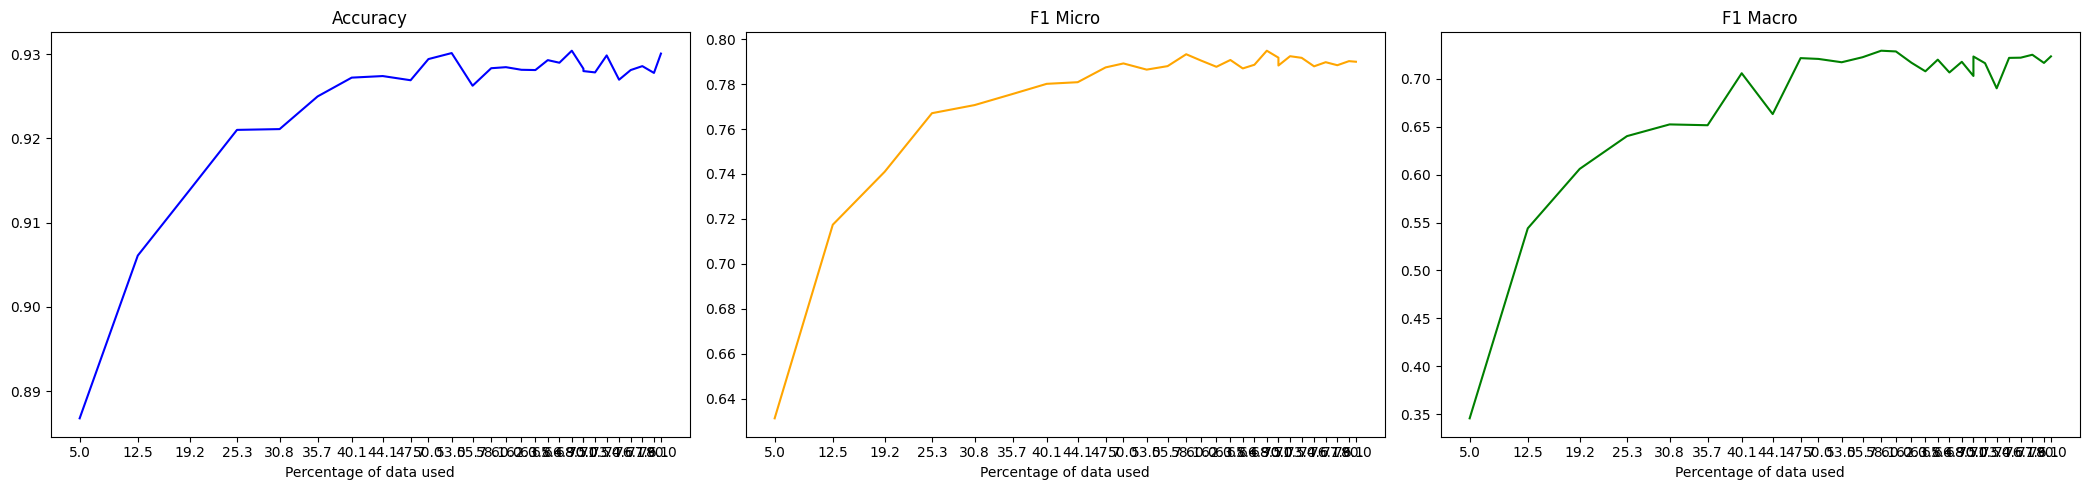

In [25]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.8348, F1 Micro: 0.1412, F1 Macro: 0.0514
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.833, F1 Micro: 0.088, F1 Macro: 0.0343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.85, F1 Micro: 0.3323, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3599, Accuracy: 0.8618, F1 Micro: 0.4297, F1 Macro: 0.1746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3369, Accuracy: 0.8752, F1 Micro: 0.5274, F1 Macro: 0.2436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2854, Accuracy: 0.8782, F1 Micro: 0.5421, F1 Macro: 0.254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2723, Accuracy: 0.8832, F1 Micro: 0.5806, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2324, Accuracy: 0.8863, F1 Micro: 0.611, F1 Macro: 0.3353
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2048, Accuracy: 0.8859, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.8269, F1 Micro: 0.3975, F1 Macro: 0.1074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.85, F1 Micro: 0.4217, F1 Macro: 0.1469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3699, Accuracy: 0.8863, F1 Micro: 0.6158, F1 Macro: 0.365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3188, Accuracy: 0.8968, F1 Micro: 0.6583, F1 Macro: 0.3912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2576, Accuracy: 0.9006, F1 Micro: 0.6654, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2213, Accuracy: 0.9019, F1 Micro: 0.705, F1 Macro: 0.509
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1814, Accuracy: 0.9017, F1 Micro: 0.7149, F1 Macro: 0.5291
Epoch 8/10, Train Loss: 0.1566, Accuracy: 0.9061, F1 Micro: 0.705, F1 Macro: 0.5034
Epoch 9/10, Train Loss: 0.1338, Accuracy: 0.9046, F1 Micro: 0.7147, F1 Macro: 0.5307
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4704, Accuracy: 0.8387, F1 Micro: 0.3931, F1 Macro: 0.1101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4004, Accuracy: 0.876, F1 Micro: 0.5291, F1 Macro: 0.2466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3386, Accuracy: 0.9023, F1 Micro: 0.6816, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2883, Accuracy: 0.9087, F1 Micro: 0.7102, F1 Macro: 0.5114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2322, Accuracy: 0.911, F1 Micro: 0.7248, F1 Macro: 0.5553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1838, Accuracy: 0.9112, F1 Micro: 0.7359, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.156, Accuracy: 0.9093, F1 Micro: 0.7368, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1297, Accuracy: 0.9136, F1 Micro: 0.741, F1 Macro: 0.5851
Epoch 9/10, Train Loss: 0.1046, Accuracy: 0.9081, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4589, Accuracy: 0.8389, F1 Micro: 0.4062, F1 Macro: 0.1126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3838, Accuracy: 0.8893, F1 Micro: 0.6597, F1 Macro: 0.4408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3223, Accuracy: 0.9079, F1 Micro: 0.7101, F1 Macro: 0.5328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2715, Accuracy: 0.9139, F1 Micro: 0.7464, F1 Macro: 0.5815
Epoch 5/10, Train Loss: 0.2138, Accuracy: 0.9164, F1 Micro: 0.7454, F1 Macro: 0.5776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1771, Accuracy: 0.9142, F1 Micro: 0.7499, F1 Macro: 0.5836
Epoch 7/10, Train Loss: 0.148, Accuracy: 0.9172, F1 Micro: 0.7468, F1 Macro: 0.5791
Epoch 8/10, Train Loss: 0.1143, Accuracy: 0.9141, F1 Micro: 0.7471, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0938, Accuracy: 0.9198, F1 Micro: 0.7504, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4566, Accuracy: 0.8402, F1 Micro: 0.4939, F1 Macro: 0.203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.375, Accuracy: 0.8973, F1 Micro: 0.6808, F1 Macro: 0.4431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3104, Accuracy: 0.9098, F1 Micro: 0.7082, F1 Macro: 0.479
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2628, Accuracy: 0.9185, F1 Micro: 0.7584, F1 Macro: 0.5958
Epoch 5/10, Train Loss: 0.2035, Accuracy: 0.9176, F1 Micro: 0.7368, F1 Macro: 0.5792
Epoch 6/10, Train Loss: 0.161, Accuracy: 0.9161, F1 Micro: 0.7584, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1278, Accuracy: 0.9195, F1 Micro: 0.7654, F1 Macro: 0.6203
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9185, F1 Micro: 0.7637, F1 Macro: 0.6264
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9187, F1 Micro: 0.759, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0807, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4512, Accuracy: 0.8621, F1 Micro: 0.5122, F1 Macro: 0.1995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3584, Accuracy: 0.9071, F1 Micro: 0.6943, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2952, Accuracy: 0.9124, F1 Micro: 0.7533, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2455, Accuracy: 0.9143, F1 Micro: 0.7589, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1983, Accuracy: 0.9208, F1 Micro: 0.7652, F1 Macro: 0.6181
Epoch 6/10, Train Loss: 0.1534, Accuracy: 0.9204, F1 Micro: 0.7575, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1218, Accuracy: 0.9206, F1 Micro: 0.7675, F1 Macro: 0.6429
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9216, F1 Micro: 0.7591, F1 Macro: 0.6352
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.9202, F1 Micro: 0.759, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4438, Accuracy: 0.8819, F1 Micro: 0.5672, F1 Macro: 0.2632
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3466, Accuracy: 0.9095, F1 Micro: 0.7146, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2879, Accuracy: 0.9182, F1 Micro: 0.7396, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2293, Accuracy: 0.9222, F1 Micro: 0.7574, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1831, Accuracy: 0.9219, F1 Micro: 0.7733, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1466, Accuracy: 0.9251, F1 Micro: 0.7736, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.123, Accuracy: 0.9238, F1 Micro: 0.776, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9254, F1 Micro: 0.777, F1 Macro: 0.6895
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9235, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4333, Accuracy: 0.8877, F1 Micro: 0.6577, F1 Macro: 0.4085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3331, Accuracy: 0.9119, F1 Micro: 0.7275, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2726, Accuracy: 0.9201, F1 Micro: 0.7658, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.9228, F1 Micro: 0.7713, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9249, F1 Micro: 0.78, F1 Macro: 0.6856
Epoch 6/10, Train Loss: 0.1435, Accuracy: 0.9252, F1 Micro: 0.7728, F1 Macro: 0.6615
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9232, F1 Micro: 0.7753, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9251, F1 Micro: 0.7837, F1 Macro: 0.7053
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9244, F1 Micro: 0.7828, F1 Macro: 0.7134
Epoch 10/10, Train Loss: 0.0708, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4228, Accuracy: 0.896, F1 Micro: 0.6673, F1 Macro: 0.4495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3137, Accuracy: 0.9135, F1 Micro: 0.7225, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.9229, F1 Micro: 0.7724, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2108, Accuracy: 0.9256, F1 Micro: 0.7819, F1 Macro: 0.6444
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9276, F1 Micro: 0.7808, F1 Macro: 0.6918
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9258, F1 Micro: 0.7819, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9247, F1 Micro: 0.7841, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9271, F1 Micro: 0.7868, F1 Macro: 0.7119
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9276, F1 Micro: 0.789, F1 Macro: 0.715
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4197, Accuracy: 0.8972, F1 Micro: 0.6453, F1 Macro: 0.4206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.9164, F1 Micro: 0.7451, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2507, Accuracy: 0.924, F1 Micro: 0.7675, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9256, F1 Micro: 0.7725, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1698, Accuracy: 0.9235, F1 Micro: 0.7844, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9258, F1 Micro: 0.7849, F1 Macro: 0.6805
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9292, F1 Micro: 0.7952, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9267, F1 Micro: 0.7872, F1 Macro: 0.7058
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9276, F1 Micro: 0.7862, F1 Macro: 0.7138
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4147, Accuracy: 0.8979, F1 Micro: 0.6644, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3007, Accuracy: 0.9177, F1 Micro: 0.7434, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2414, Accuracy: 0.9244, F1 Micro: 0.7689, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1965, Accuracy: 0.925, F1 Micro: 0.784, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9263, F1 Micro: 0.7829, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9266, F1 Micro: 0.7843, F1 Macro: 0.7082
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9282, F1 Micro: 0.7852, F1 Macro: 0.7009
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9277, F1 Micro: 0.784, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9278, F1 Micro: 0.7857, F1 Macro: 0.7166
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4035, Accuracy: 0.8993, F1 Micro: 0.6605, F1 Macro: 0.4457
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2936, Accuracy: 0.9163, F1 Micro: 0.7593, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.921, F1 Micro: 0.7731, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9275, F1 Micro: 0.7861, F1 Macro: 0.6628
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9255, F1 Micro: 0.781, F1 Macro: 0.6599
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9249, F1 Micro: 0.785, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9289, F1 Micro: 0.7892, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9274, F1 Micro: 0.7893, F1 Macro: 0.7176
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9245, F1 Micro: 0.784, F1 Macro: 0.7194
Epoch 10/10, Train Loss: 0.0603, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3965, Accuracy: 0.8999, F1 Micro: 0.6497, F1 Macro: 0.4268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2842, Accuracy: 0.918, F1 Micro: 0.7537, F1 Macro: 0.5755
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9206, F1 Micro: 0.7508, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.927, F1 Micro: 0.7756, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9281, F1 Micro: 0.7868, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9282, F1 Micro: 0.7925, F1 Macro: 0.7024
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9275, F1 Micro: 0.7859, F1 Macro: 0.7147
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.929, F1 Micro: 0.7883, F1 Macro: 0.7062
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9261, F1 Micro: 0.7874, F1 Macro: 0.7149
Epoch 10/10, Train Loss: 0.0571, Accuracy: 0.9281, F1 Micro: 0.7823, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3929, Accuracy: 0.9039, F1 Micro: 0.7016, F1 Macro: 0.4927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9171, F1 Micro: 0.7504, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2251, Accuracy: 0.9176, F1 Micro: 0.7726, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9271, F1 Micro: 0.7774, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9258, F1 Micro: 0.7871, F1 Macro: 0.6733
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9249, F1 Micro: 0.7804, F1 Macro: 0.6712
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.9253, F1 Micro: 0.7846, F1 Macro: 0.7085
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9292, F1 Micro: 0.7885, F1 Macro: 0.7219
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.929, F1 Micro: 0.7848, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.9025, F1 Micro: 0.6825, F1 Macro: 0.4755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.9204, F1 Micro: 0.7586, F1 Macro: 0.6023
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9227, F1 Micro: 0.7494, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9265, F1 Micro: 0.7785, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9269, F1 Micro: 0.7865, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9276, F1 Micro: 0.7908, F1 Macro: 0.71
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9265, F1 Micro: 0.7856, F1 Macro: 0.71
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9278, F1 Micro: 0.7891, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.9291, F1 Micro: 0.7915, F1 Macro: 0.7217
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.9054, F1 Micro: 0.7184, F1 Macro: 0.5466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.9194, F1 Micro: 0.7378, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9244, F1 Micro: 0.7722, F1 Macro: 0.6251
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9266, F1 Micro: 0.7684, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9285, F1 Micro: 0.7862, F1 Macro: 0.689
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.925, F1 Micro: 0.7825, F1 Macro: 0.6981
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.925, F1 Micro: 0.7805, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9267, F1 Micro: 0.7899, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9291, F1 Micro: 0.7876, F1 Macro: 0.7268
Epoch 10/10, Train Loss: 0.0519, Accuracy: 0.9282, F1 Micro: 0.7864, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3699, Accuracy: 0.9024, F1 Micro: 0.6789, F1 Macro: 0.4158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.9156, F1 Micro: 0.7578, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9234, F1 Micro: 0.7776, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9269, F1 Micro: 0.7821, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9255, F1 Micro: 0.7825, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9268, F1 Micro: 0.7883, F1 Macro: 0.7017
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9283, F1 Micro: 0.787, F1 Macro: 0.7083
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9248, F1 Micro: 0.7832, F1 Macro: 0.7186
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9257, F1 Micro: 0.7838, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.9049, F1 Micro: 0.7145, F1 Macro: 0.5292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.9209, F1 Micro: 0.7546, F1 Macro: 0.6012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9233, F1 Micro: 0.7672, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9222, F1 Micro: 0.7807, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9251, F1 Micro: 0.7842, F1 Macro: 0.666
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9252, F1 Micro: 0.7818, F1 Macro: 0.694
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.928, F1 Micro: 0.7775, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9271, F1 Micro: 0.7852, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9257, F1 Micro: 0.7853, F1 Macro: 0.7193
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.9043, F1 Micro: 0.71, F1 Macro: 0.4781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.9195, F1 Micro: 0.7619, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9253, F1 Micro: 0.764, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9237, F1 Micro: 0.7849, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.925, F1 Micro: 0.7868, F1 Macro: 0.6897
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9254, F1 Micro: 0.7807, F1 Macro: 0.6885
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9284, F1 Micro: 0.7887, F1 Macro: 0.706
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9266, F1 Micro: 0.7802, F1 Macro: 0.7104
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9272, F1 Micro: 0.7813, F1 Macro: 0.7156
Epoch 10/10, Train Loss: 0.0538, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8998, F1 Micro: 0.6474, F1 Macro: 0.4591
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9159, F1 Micro: 0.756, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9267, F1 Micro: 0.7815, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9273, F1 Micro: 0.7854, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9263, F1 Micro: 0.7876, F1 Macro: 0.7026
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.9234, F1 Micro: 0.7802, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9283, F1 Micro: 0.7921, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9297, F1 Micro: 0.7919, F1 Macro: 0.7221
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9284, F1 Micro: 0.788, F1 Macro: 0.73
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3589, Accuracy: 0.9007, F1 Micro: 0.6549, F1 Macro: 0.4881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.9191, F1 Micro: 0.7675, F1 Macro: 0.6064
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9251, F1 Micro: 0.7636, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9279, F1 Micro: 0.7784, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9271, F1 Micro: 0.7883, F1 Macro: 0.7003
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9266, F1 Micro: 0.7871, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9286, F1 Micro: 0.792, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9289, F1 Micro: 0.794, F1 Macro: 0.7312
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9271, F1 Micro: 0.7893, F1 Macro: 0.727
Epoch 10/10, Train Loss: 0.0481, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.9047, F1 Micro: 0.6985, F1 Macro: 0.5187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9207, F1 Micro: 0.7656, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.926, F1 Micro: 0.7817, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.924, F1 Micro: 0.7829, F1 Macro: 0.6555
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.928, F1 Micro: 0.7804, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9299, F1 Micro: 0.7937, F1 Macro: 0.7121
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9267, F1 Micro: 0.7865, F1 Macro: 0.7203
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9245, F1 Micro: 0.7847, F1 Macro: 0.7205
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9255, F1 Micro: 0.7806, F1 Macro: 0.7155
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0471, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3453, Accuracy: 0.9031, F1 Micro: 0.6774, F1 Macro: 0.4403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9199, F1 Micro: 0.7543, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9261, F1 Micro: 0.7785, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9278, F1 Micro: 0.7834, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9241, F1 Micro: 0.785, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9284, F1 Micro: 0.7885, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9292, F1 Micro: 0.7946, F1 Macro: 0.7318
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9301, F1 Micro: 0.7901, F1 Macro: 0.7223
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.927, F1 Micro: 0.788, F1 Macro: 0.7269
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3432, Accuracy: 0.9054, F1 Micro: 0.6844, F1 Macro: 0.4404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.9209, F1 Micro: 0.7727, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9257, F1 Micro: 0.7833, F1 Macro: 0.6486
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.923, F1 Micro: 0.7795, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9287, F1 Micro: 0.7891, F1 Macro: 0.6864
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9259, F1 Micro: 0.7832, F1 Macro: 0.7023
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9267, F1 Micro: 0.7867, F1 Macro: 0.7194
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.926, F1 Micro: 0.782, F1 Macro: 0.7118
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9278, F1 Micro: 0.7901, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.043, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.9042, F1 Micro: 0.7007, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2262, Accuracy: 0.9202, F1 Micro: 0.7664, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9241, F1 Micro: 0.7812, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9284, F1 Micro: 0.7819, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9284, F1 Micro: 0.7859, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.928, F1 Micro: 0.7891, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9297, F1 Micro: 0.7892, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9269, F1 Micro: 0.7892, F1 Macro: 0.725
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9244, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3308, Accuracy: 0.9078, F1 Micro: 0.7087, F1 Macro: 0.505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2204, Accuracy: 0.9191, F1 Micro: 0.741, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9255, F1 Micro: 0.7722, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1447, Accuracy: 0.929, F1 Micro: 0.7833, F1 Macro: 0.6804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9292, F1 Micro: 0.7851, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9305, F1 Micro: 0.7888, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9311, F1 Micro: 0.7992, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9276, F1 Micro: 0.788, F1 Macro: 0.716
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9253, F1 Micro: 0.7875, F1 Macro: 0.7278
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9037, F1 Micro: 0.7152, F1 Macro: 0.5077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9218, F1 Micro: 0.7614, F1 Macro: 0.5864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.9167, F1 Micro: 0.7711, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9278, F1 Micro: 0.7803, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9259, F1 Micro: 0.7816, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9253, F1 Micro: 0.7823, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9291, F1 Micro: 0.7911, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9285, F1 Micro: 0.7899, F1 Macro: 0.7227
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9276, F1 Micro: 0.7847, F1 Macro: 0.719
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3265, Accuracy: 0.9078, F1 Micro: 0.7132, F1 Macro: 0.514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2116, Accuracy: 0.9186, F1 Micro: 0.7386, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9259, F1 Micro: 0.7806, F1 Macro: 0.6367
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9209, F1 Micro: 0.7786, F1 Macro: 0.6807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.93, F1 Micro: 0.7867, F1 Macro: 0.692
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.921, F1 Micro: 0.7833, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9257, F1 Micro: 0.7921, F1 Macro: 0.7221
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9249, F1 Micro: 0.7861, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9284, F1 Micro: 0.7944, F1 Macro: 0.7299
Epoch 10/10, Train Loss: 0.0389, Accuracy: 

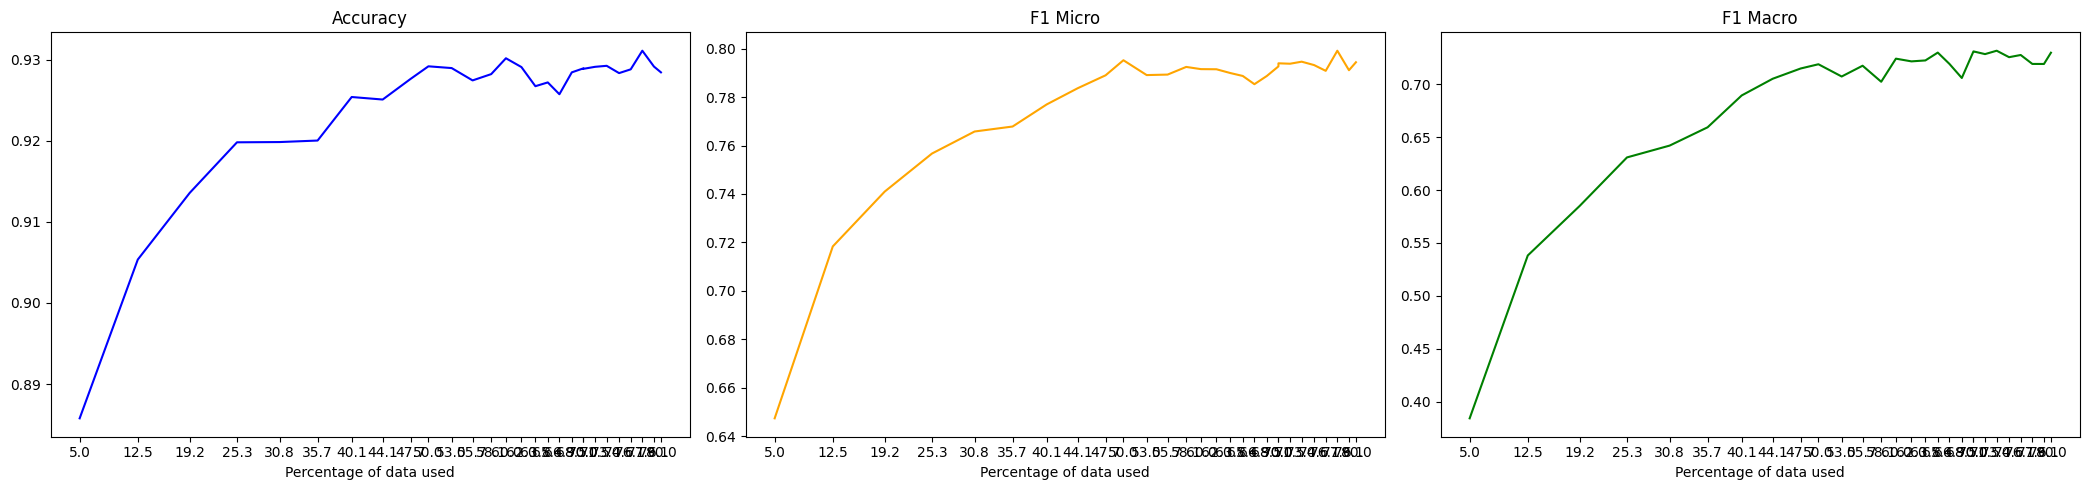

In [26]:
active_learning(seeds[4], 4)